# Overview: checking metadata and samplesheet for all RUNS

## Preparation

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import pathlib
import pysam
import pyfaidx
import warnings
import re
import argparse
import sys
import subprocess
from tqdm import tqdm 

tqdm.pandas()
warnings.filterwarnings("ignore")

main_outptudir = "/workdir/outdir/pipeline_output"
umt_distance = 1
analysis_output_version = "20250614"

name = "Truong"

path_to_main_output = os.path.join(main_outptudir, "data_analysis", name, analysis_output_version)
path_to_01_output = os.path.join(path_to_main_output, "01_output")
os.system(f"mkdir -p {path_to_01_output}")

rundf = pd.read_excel("../panel_design/All_panel_designs_20250601.xlsx", sheet_name="Runs_tracking")
rundf.columns = ["Run", "SampleID", "UMI", "Panel_version", "Name", "amplicon_name", "serial"]

umi_rundf = rundf[(rundf["UMI"] == "Yes") & (rundf["Name"] == name) ]

collect_all_sample_sheets = [item for item in pathlib.Path("../experiments/").glob("SampleSheet_batch_*.csv")]

samplesheet = pd.DataFrame()
for file in collect_all_sample_sheets:
    df = pd.read_csv(file, sep=",")
    df["batch"] = file.name.replace(".csv", "")
    samplesheet = pd.concat([samplesheet, df], ignore_index=True)

samplesheet.columns = ["filename", "FASTQ1", "FASTQ2", "batch"]
samplesheet["Run"] = samplesheet["FASTQ1"].apply(lambda x: x.split("/")[5] if x.split("/")[5] != "2025" else x.split("/")[6])
samplesheet["SampleID"] = samplesheet["filename"].apply(lambda x: x.split("_")[0].split("-")[1])
print(f"All available runs: {", ".join(sorted(samplesheet['Run'].unique()))}")

samplesheet["SampleID"] = samplesheet[["FASTQ1", "SampleID"]].apply(
    lambda x: f"{x[1]}_{x[0].split("2025")[1].split("/")[2]}".replace("BCDMR", "") if "BCDMR" in x[1] else x[1], axis = 1
)

All available runs: R7288, R7297, R7312, R7331, R7332, R7347, R7353, R7373, R7374, R7381, R7393, R7400


## Check if there is any missing FASTQ samples

In [2]:
missing_fastq = [item for item in umi_rundf.SampleID.unique() if item not in samplesheet.SampleID.unique()]

umi_rundf[umi_rundf.SampleID.isin(missing_fastq)]


,Run,SampleID,UMI,Panel_version,Name,amplicon_name,serial


## Match output paths to main metadata

since there is duplicated SampleID, we should merge labcode and Run together to make them unique

In [3]:
rerun = False
if (os.path.isfile(os.path.join(path_to_01_output, "UMI_runs_tracking.xlsx")) == False) | (rerun  == True):
    umi_rundf["uniqueID"] = umi_rundf[["SampleID", "Run"]].apply(lambda x: f"{x[0]}_{x[1]}", axis=1)
    samplesheet["uniqueID"] = samplesheet[["SampleID", "Run"]].apply(lambda x: f"{x[0]}_{x[1]}", axis=1)

    final_umi_rundf = umi_rundf.merge(samplesheet.drop(["SampleID", "Run"], axis = 1), left_on = "uniqueID", right_on = "uniqueID")
    final_umi_rundf["UMI_cov_file"] = final_umi_rundf[["batch", "filename"]].apply(lambda x: os.path.join(
        main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_COV", f"{x[1]}.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov"
    ), axis = 1)
    final_umi_rundf["nonUMI_cov_file"] = final_umi_rundf[["batch", "filename"]].apply(lambda x: os.path.join(
        main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_COV", f"{x[1]}.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov"
    ), axis = 1)

    final_umi_rundf["check_UMI"] = final_umi_rundf["UMI_cov_file"].apply(lambda x: os.path.exists(x))
    final_umi_rundf["check_nonUMI"] = final_umi_rundf["nonUMI_cov_file"].apply(lambda x: os.path.exists(x))

    final_umi_rundf["unmapped_bam"] = final_umi_rundf[["batch", "filename"]].apply(
        lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_ALIGNMENT_UNMAPPED_BAM", f"{x[1]}_R1.UMIprocessed_bismark_bt2_pe.bam"), axis = 1
    )
    final_umi_rundf["connor_annotated"] = final_umi_rundf[["batch", "filename"]].apply(
        lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "CONNOR_UMI_OUTPUT", f"{x[1]}.connor.fully_annotated.bam"), axis = 1
    )
    final_umi_rundf["connor_fastq"] = final_umi_rundf[["batch", "filename"]].apply(
        lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "CONNOR_UMI_OUTPUT", f"{x[1]}.connor_R1.fastq.gz"), axis = 1
    )
    final_umi_rundf["umi_bam"] = final_umi_rundf[["batch", "filename"]].apply(
        lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_ALIGNMENT", f"{x[1]}.connor_R1_bismark_bt2_pe.sorted.bam"), axis = 1
    )
    final_umi_rundf["non_umi_bam"] = final_umi_rundf[["batch", "filename"]].apply(
        lambda x: os.path.join(main_outptudir, x[0], f"UMT_DISTANCE_{umt_distance}", "BISMARK_ALIGNMENT", f"{x[1]}.CutAdapt_R1_bismark_bt2_pe.sorted.bam"), axis = 1
    )

    tqdm.pandas()
    for col in ["unmapped_bam", "connor_annotated", "connor_fastq", "umi_bam", "non_umi_bam" , "UMI_cov_file"]:
        print(f"working on column: {col}")
        def _get_line_count(x):
            check_file = os.path.exists(x)
            x_raw = x.replace(".sorted.bam", ".bam")
            if check_file == False:
                if os.path.exists(x_raw) == True: 
                    # print(f"sorted bam file is not available, but raw bam file is available, sorting and indexing it now...")
                    os.system(f"samtools sort -@ 15 {x_raw} -o {x}")
                    os.system(f"samtools index {x}")
                else:
                    # rint(f"File {x} does not exist, skipping line count for this file.")
                    return 0
            if ".bam" in x:
                result = subprocess.run(f"samtools view {x} -c", shell=True, capture_output=True, text=True)
            elif ".fastq.gz" in x:
                result = subprocess.run(f"zcat {x} | wc -l", shell=True, capture_output=True, text=True)
            else:
                result = subprocess.run(f"cat {x} | wc -l", shell=True, capture_output=True, text=True)
            return int(result.stdout.strip())
            
        final_umi_rundf[f"count_{col}"] = final_umi_rundf[col].progress_apply(_get_line_count)    
    # small size fastq
    final_umi_rundf["small_FASTQ_size"] = final_umi_rundf["FASTQ1"].apply(lambda x: "smallsize" in x)
    final_umi_rundf.groupby("small_FASTQ_size")["SampleID"].count()
    final_umi_rundf.to_excel(os.path.join(path_to_01_output, "UMI_runs_tracking.xlsx"), index=False)
else:
    print("reading in saved processed UMI runs tracking file...")
    final_umi_rundf = pd.read_excel(os.path.join(path_to_01_output, "UMI_runs_tracking.xlsx"))

reading in saved processed UMI runs tracking file...


## Small size FASTQ

In [4]:
final_umi_rundf[final_umi_rundf["small_FASTQ_size"] == True]

,Run,SampleID,UMI,Panel_version,Name,amplicon_name,serial,uniqueID,filename,FASTQ1,...,connor_fastq,umi_bam,non_umi_bam,count_unmapped_bam,count_connor_annotated,count_connor_fastq,count_umi_bam,count_non_umi_bam,count_UMI_cov_file,small_FASTQ_size
29,R7381,ST7_0,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST7_0_R7381,13-ST7BCDMR__S7576-S7776,/mnt/GS-BACKUP05/FASTQ/2025/R7381/0/smallsize/...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,280,228,4,0,280,0,True
30,R7381,ST7_1,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST7_1_R7381,14-ST7BCDMR__S7577-S7777,/mnt/GS-BACKUP05/FASTQ/2025/R7381/1/smallsize/...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,416,332,0,0,416,0,True
32,R7381,ST7_10,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST7_10_R7381,16-ST7BCDMR__S7579-S7779,/mnt/GS-BACKUP05/FASTQ/2025/R7381/10/smallsize...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,362,292,0,0,362,0,True
36,R7381,ST8_1,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST8_1_R7381,20-ST8BCDMR__S7583-S7783,/mnt/GS-BACKUP05/FASTQ/2025/R7381/1/smallsize/...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,98708,30565,12,4,98708,4,True
38,R7381,ST8_10,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST8_10_R7381,22-ST8BCDMR__S7585-S7785,/mnt/GS-BACKUP05/FASTQ/2025/R7381/10/smallsize...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,143964,45563,16,2,143964,4,True
39,R7381,ST8_50,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST8_50_R7381,23-ST8BCDMR__S7586-S7786,/mnt/GS-BACKUP05/FASTQ/2025/R7381/50/smallsize...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,152588,46990,8,2,152588,4,True
40,R7381,ST8_100,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST8_100_R7381,24-ST8BCDMR__S7587-S7787,/mnt/GS-BACKUP05/FASTQ/2025/R7381/100/smallsiz...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,161108,50416,12,2,161108,4,True
42,R7400,ST1_1,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST1_1_R7400,2-ST1BCDMR__S7502-S7702,/mnt/GS-BACKUP05/FASTQ/2025/R7400/1/smallsize/...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,166316,129388,1836,6,166316,2,True
52,R7400,ST2_100,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST2_100_R7400,12-ST2BCDMR__S7516-S7716,/mnt/GS-BACKUP05/FASTQ/2025/R7400/100/smallsiz...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,97876,61005,792,28,97876,2,True
64,R7400,ST12_100,Yes,Truong_amplicon_PBMC_v1.1,Truong,NaN,NaN,ST12_100_R7400,24-ST12BCDMR__S7528-S7728,/mnt/GS-BACKUP05/FASTQ/2025/R7400/100/smallsiz...,...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,/workdir/outdir/pipeline_output/SampleSheet_ba...,107422,63510,1104,56,107422,4,True


# Helper functions

In [5]:
# panel_name = "Lung_panel version 1.1"
# cpgdf = pd.DataFrame()
# panel_name = panel_name.replace(" ", "_")
# paneldf = pd.read_excel("../panel_design/All_panel_designs_20250601.xlsx", sheet_name=panel_name)
# paneldf[f"{genome_version}_org"] = paneldf[genome_version].values
# paneldf["lengthF"] = paneldf["Forward Primer Seq"].apply(lambda x: len(x))
# paneldf["lengthR"] = paneldf["Reverse Primer Seq"].apply(lambda x: len(x))

def _remove_primer_coords(x, lenF, lenR):
    chrom = x.split(":")[0]
    start = int(x.split(":")[1].split("-")[0])
    end = int(x.split(":")[1].split("-")[1])
    start = start + lenF - 1
    end = end - lenR + 1
    return f"{chrom}:{start}-{end}"

def get_refseq(path_to_all_fa, chrom, start, end):
        refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "{}.fa".format(chrom)))
        return(str.upper(refseq.get_seq(name = "{}".format(chrom), start = start, end = end).seq))

path_to_all_fa = "/home/hieunguyen/resources/hg19"
genome_version = "hg19"

##### get list of all real cpg for this panel
all_cpgdf = dict()
all_cpgdf_with_primer = dict()
all_paneldf = dict()
for panel_name in final_umi_rundf.Panel_version.unique():
    
    panel_name = panel_name.replace(" ", "_")
    paneldf = pd.read_excel("../panel_design/All_panel_designs_20250601.xlsx", sheet_name=panel_name)
    paneldf[f"{genome_version}_org"] = paneldf[genome_version].values
    paneldf["lengthF"] = paneldf["Forward Primer Seq"].apply(lambda x: len(x))
    paneldf["lengthR"] = paneldf["Reverse Primer Seq"].apply(lambda x: len(x))
    paneldf[genome_version] = paneldf[[genome_version, "lengthF", "lengthR"]].apply(lambda x:_remove_primer_coords(x[0], x[1], x[2]), axis = 1)

    def generate_cpgdf(region_col, paneldf):
        outputdf = pd.DataFrame()
        print(f"working on panel: {panel_name}, with {len(paneldf[region_col].unique())} regions")
        for region in paneldf[region_col].unique():
            region_name = paneldf[paneldf[region_col] == region]["Amplicon"].values[0]
            chrom = region.split(":")[0].replace("Chr", "chr").replace("chr", "")
            start = int(region.split(":")[1].split("-")[0])
            end = int(region.split(":")[1].split("-")[1])
            refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "chr{}.fa".format(chrom)))
            refseq_at_region = str.upper(refseq.get_seq(name = "chr{}".format(chrom), start = start, end = end).seq)

            all_cpg_in_cluster = [m.start(0) for m in re.finditer("CG", refseq_at_region)]
            cpg_coords = [f"chr{chrom}:{item + start}-{item + start + 1}" for item in all_cpg_in_cluster]

            tmp_outputdf = pd.DataFrame(data = cpg_coords, columns = ["CpG"])
            tmp_outputdf["region"] = region
            tmp_outputdf["region_name"] = region_name
            outputdf = pd.concat([outputdf, tmp_outputdf], axis = 0)
        print(f"outputdf shape after adding region {region}: {outputdf.shape}")
        return outputdf
    
    cpgdf = generate_cpgdf(genome_version, paneldf)
    cpgdf_with_primer = generate_cpgdf(f"{genome_version}_org", paneldf)
    
    cpgdf = cpgdf[["region", "CpG", "region_name"]]
    all_cpgdf[panel_name] = cpgdf.copy()

    cpgdf_with_primer = cpgdf_with_primer[["region", "CpG", "region_name"]]
    all_cpgdf_with_primer[panel_name] = cpgdf_with_primer.copy()

    all_paneldf[panel_name] = paneldf.copy()

# for i in all_cpgdf.keys():
#     tmpdf1 = all_cpgdf[i].copy()
#     tmpdf2 = all_cpgdf_with_primer[i].copy()
#     assert tmpdf1.shape[0] == tmpdf2.shape[0], f"Error: {i} cpgdf and cpgdf_with_primer have different number of rows"


working on panel: Truong_amplicon_PBMC_v1.1, with 15 regions
outputdf shape after adding region chr10:42384894-42385007: (51, 3)
working on panel: Truong_amplicon_PBMC_v1.1, with 15 regions
outputdf shape after adding region chr10:42384864-42385033 : (54, 3)


In [6]:
paneldf

,Amplicon,hg19,Amplicon length,Strand,Adapter_F,UMI,Barcode_F,Forward Primer Seq,Forward Primer Final,Adapter_R,Barcode_R,Reverse Primer Seq,Reverse Primer Final,hg19_org,lengthF,lengthR
0,D1F1,chr3:3151958-3152084,181,-,ACACGACGCTCTTCCGATCT,NNNNNN,CCA,GTGTTGTTTAGGAGATAGAGGTATAGTA,ACACGACGCTCTTCCGATCTNNNNNNCCAGTGTTGTTTAGGAGATA...,GACGTGTGCTCTTCCGATCT,CGG,ATCTACATTTTCACTCTCTTTCAAAATT,GACGTGTGCTCTTCCGATCTCGGATCTACATTTTCACTCTCTTTCA...,chr3:3151931-3152111,28,28
1,D1F2,chr3:3152196-3152298,157,-,ACACGACGCTCTTCCGATCT,NNNNNN,CCA,ATAATTTGTGTAGGATGATTTTAGGTGA,ACACGACGCTCTTCCGATCTNNNNNNCCAATAATTTGTGTAGGATG...,GACGTGTGCTCTTCCGATCT,CCG,ACAATAACAACAATTCTCTACCCTTAAA,GACGTGTGCTCTTCCGATCTCCGACAATAACAACAATTCTCTACCC...,chr3:3152169-3152325,28,28
2,D1F5,chr3:3152848-3152950,158,-,ACACGACGCTCTTCCGATCT,NNNNNN,CCA,GGGTGTTTTTTAGTAAATAAATGGATTTT,ACACGACGCTCTTCCGATCTNNNNNNCCAGGGTGTTTTTTAGTAAA...,GACGTGTGCTCTTCCGATCT,GAC,TCCCAAAATAACCATTTTAACAATTACC,GACGTGTGCTCTTCCGATCTGACTCCCAAAATAACCATTTTAACAA...,chr3:3152820-3152977,29,28
3,D1F6,chr3:3152517-3152631,169,+,ACACGACGCTCTTCCGATCT,NNNNNN,CCA,GTGGTTAGTTAGTAAAGTTGGTTTTAAA,ACACGACGCTCTTCCGATCTNNNNNNCCAGTGGTTAGTTAGTAAAG...,GACGTGTGCTCTTCCGATCT,CGA,TCCTAAAAAAACAAAAAATCCTACATCA,GACGTGTGCTCTTCCGATCTCGATCCTAAAAAAACAAAAAATCCTA...,chr3:3152490-3152658,28,28
4,D2F2,chr2:102953419-102953532,168,-,ACACGACGCTCTTCCGATCT,NNNNNN,GGC,TTGAGTAATTTTTTGAGAGGAAATAATT,ACACGACGCTCTTCCGATCTNNNNNNGGCTTGAGTAATTTTTTGAG...,GACGTGTGCTCTTCCGATCT,CCA,AATATCTAAAAAAACAACCTCCAAATCC,GACGTGTGCTCTTCCGATCTCCAAATATCTAAAAAAACAACCTCCA...,chr2:102953392-102953559,28,28
5,D2F3,chr2:102953732-102953778,101,+,ACACGACGCTCTTCCGATCT,NNNNNN,CCA,TGAGTAGTTTATGAGGAGGGATTTATAA,ACACGACGCTCTTCCGATCTNNNNNNCCATGAGTAGTTTATGAGGA...,GACGTGTGCTCTTCCGATCT,CCA,ATACTTACCCAAACTAAAAAACAAAAAA,GACGTGTGCTCTTCCGATCTCCAATACTTACCCAAACTAAAAAACA...,chr2:102953705-102953805,28,28
6,D3F2,chr2:240067222-240067316,149,-,ACACGACGCTCTTCCGATCT,NNNNNN,GCA,GAATTTAAAGGTTTGTGTGATATAYGTT,ACACGACGCTCTTCCGATCTNNNNNNGCAGAATTTAAAGGTTTGTG...,GACGTGTGCTCTTCCGATCT,CGG,CCRCCTTAAAAAACACTAAAAATCTAAA,GACGTGTGCTCTTCCGATCTCGGCCRCCTTAAAAAACACTAAAAAT...,chr2:240067195-240067343,28,28
7,D5F2,chr10:42390429-42390512,140,+,ACACGACGCTCTTCCGATCT,NNNNNN,GCA,TGAAATTTAATGTGATTATTATTGAATGGA,ACACGACGCTCTTCCGATCTNNNNNNGCATGAAATTTAATGTGATT...,GACGTGTGCTCTTCCGATCT,CCG,TCCATTTCAATTTCATAATAATTCCATT,GACGTGTGCTCTTCCGATCTCCGTCCATTTCAATTTCATAATAATT...,chr10:42390400-42390539,30,28
8,D7F1,chr3:45942345-45942464,174,+,ACACGACGCTCTTCCGATCT,NNNNNN,GCA,TGGTTGATGATTATGGTTTTGAATTTAT,ACACGACGCTCTTCCGATCTNNNNNNGCATGGTTGATGATTATGGT...,GACGTGTGCTCTTCCGATCT,GAC,AAATAACAAAACTATTACCCAAAACACC,GACGTGTGCTCTTCCGATCTGACAAATAACAAAACTATTACCCAAA...,chr3:45942318-45942491,28,28
9,D7F2,chr3:45942527-45942629,157,+,ACACGACGCTCTTCCGATCT,NNNNNN,GCA,TGGTATTGTATAAGAGTGAAGATTATGA,ACACGACGCTCTTCCGATCTNNNNNNGCATGGTATTGTATAAGAGT...,GACGTGTGCTCTTCCGATCT,CGA,ACATACTATTAACCACCTTACACATAAA,GACGTGTGCTCTTCCGATCTCGAACATACTATTAACCACCTTACAC...,chr3:45942500-45942656,28,28


# PROCESSING COV FILES

In [7]:

def generate_cov(input_cov_file, panel_name, sampleid, outputdir):
    os.system(f"mkdir -p {outputdir}")
    if os.path.exists(input_cov_file) == False:
        print(f"Input coverage file {input_cov_file} does not exist, skipping...")
        covdf = pd.DataFrame(columns=["chrom", "start", "end", "meth_density", "countC", "countT", "seq", "strand", "CpG", "check_context", "amplicon"])
        status = "File not available"
    else:
        print(f"Processing {input_cov_file} for panel {panel_name}...")
        # get list of CpG which are not in primer regions
        cpgdf = all_cpgdf[panel_name]
        covdf = pd.read_csv(input_cov_file, header = None, sep = "\t")
        covdf.columns = ["chrom", "start", "end", "meth_density", "countC", "countT"]
        if covdf.shape[0] != 0:
            covdf = covdf[covdf["chrom"].isin(["chrX", "chrY", "chrMT"]) == False]
            covdf = covdf[covdf["chrom"].str.contains("chrUn") == False]
            covdf = covdf[covdf["chrom"].str.contains("_") == False]
            covdf["seq"] = covdf[["chrom", "start"]].progress_apply(lambda x: get_refseq(path_to_all_fa= path_to_all_fa, 
                                                                    chrom = x[0], start = x[1], end = x[1] + 1), axis = 1)
            covdf["strand"] = covdf["seq"].apply(lambda x: "+" if x != "CG" else "-")
            covdf_raw = covdf.copy()
            covdf["start"] = covdf[["seq", "start"]].apply(lambda x: x[1] + 1 if x[0] != "CG" else x[1], axis = 1)

            covdf["chrom"] = covdf["chrom"].apply(lambda x: str(x))
            covdf["CpG"] = covdf[["chrom", "start"]].apply(lambda x: f"{str(x[0])}:{x[1]}-{x[1] + 1}", axis = 1)
            covdf["check_context"] = covdf["CpG"].apply(lambda x: "CpG_context" if x in cpgdf["CpG"].values else "False")
            covdf["amplicon"] = covdf["CpG"].apply(lambda x: cpgdf[cpgdf["CpG"] == x]["region_name"].values[0] if x in cpgdf["CpG"].values else "NA")
            status = "Processed"
        else:
            print(f"Coverage file {input_cov_file} is empty, skipping...")
            covdf = pd.DataFrame(columns=["chrom", "start", "end", "meth_density", "countC", "countT", "seq", "strand", "CpG", "check_context", "amplicon"])
            status = "Empty file"
        covdf.to_excel(os.path.join(outputdir, f"{sampleid}.xlsx"))
    return status, os.path.join(outputdir, f"{sampleid}.xlsx")

# mode = "UMI"  # or "ignore_UMI" 
for mode in ["UMI", "ignore_UMI"]:
    all_status = []
    all_finished_path = []
    for j in range(final_umi_rundf.shape[0]):
        panel_name = final_umi_rundf.Panel_version.values[j].replace(" ", "_")
        run = final_umi_rundf.Run.values[j]
        sampleid = final_umi_rundf.SampleID.values[j]
        if mode == "UMI":
            input_cov_file = final_umi_rundf.UMI_cov_file.values[j]
        elif mode == "ignore_UMI":
            input_cov_file = final_umi_rundf.nonUMI_cov_file.values[j]

        outputdir = os.path.join(path_to_01_output, "cov", run, panel_name, mode)
        status, output_cov_path = generate_cov(input_cov_file=input_cov_file, panel_name=panel_name, sampleid=sampleid, outputdir=outputdir)
        all_status.append(status)
        all_finished_path.append(output_cov_path)
    final_umi_rundf[f"{mode}_status"] = all_status
    final_umi_rundf[f"{mode}_processed_cov"] = all_finished_path

Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/1-DMR1_S7594-S7794.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 35/35 [00:00<00:00, 10083.85it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/2-DMR2_S7595-S7795.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 26/26 [00:00<00:00, 10016.71it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/3-DMR3_S7596-S7796.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 24/24 [00:00<00:00, 9182.93it/s]

Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/1-DDM1_S7537-S7737.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...



100%|██████████| 2/2 [00:00<00:00, 2762.14it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/2-DDM2_S7538-S7738.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2618.17it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/3-DDM3_S7539-S7739.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2727.12it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/4-DDM5_S7545-S7745.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 1/1 [00:00<00:00, 2015.52it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/5-DDM6_S7547-S7747.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 7007.38it/s]


Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/6-DDM7_S7548-S7748.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/7-DDM8_S7550-S7750.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 5626.16it/s]


Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/8-DDM9_S7551-S7751.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/9-DDM10_S7553-S7753.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/10-DDM11_S7554-S7754.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 10/10 [00:00<00:00, 7207.95it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/11-DDM12_S7555-S7755.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4293.04it/s]


Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/12-DDM13_S7561-S7761.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/13-DDM14_S7562-S7762.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 20/20 [00:00<00:00, 9612.25it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/14-DDM15_S7563-S7763.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2509.31it/s]


Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/1-ST4BCDMR__S7564-S7764.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/2-ST4BCDMR__S7565-S7765.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/3-ST4BCDMR__S7566-S7766.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/4-ST4BCDMR__S7567-S7767.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/5-ST4BCDMR__S7568-S7768.connor_R1_bismark_bt2_

100%|██████████| 10/10 [00:00<00:00, 7348.11it/s]


Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/8-ST6BCDMR__S7571-S7771.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/9-ST6BCDMR__S7572-S7772.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 8/8 [00:00<00:00, 6878.73it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/10-ST6BCDMR__S7573-S7773.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 7332.70it/s]


Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/11-ST6BCDMR__S7574-S7774.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/12-ST6BCDMR__S7575-S7775.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/13-ST7BCDMR__S7576-S7776.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/14-ST7BCDMR__S7577-S7777.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/15-ST7BCDMR__S7578-S7778.connor_R1_bismark

100%|██████████| 4/4 [00:00<00:00, 4465.59it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/20-ST8BCDMR__S7583-S7783.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4534.38it/s]


Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/21-ST8BCDMR__S7584-S7784.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...
Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/22-ST8BCDMR__S7585-S7785.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4306.27it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/23-ST8BCDMR__S7586-S7786.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 3761.71it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/24-ST8BCDMR__S7587-S7787.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4591.47it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/1-ST1BCDMR__S7501-S7701.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2811.20it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/2-ST1BCDMR__S7502-S7702.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2833.03it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/3-ST1BCDMR__S7503-S7703.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2627.19it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/4-ST1BCDMR__S7504-S7704.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 3020.74it/s]

Input coverage file /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/5-ST1BCDMR__S7505-S7705.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov does not exist, skipping...


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/6-ST1BCDMR__S7506-S7706.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2558.28it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/7-ST2BCDMR__S7507-S7707.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2484.04it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/8-ST2BCDMR__S7508-S7708.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2823.50it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/9-ST2BCDMR__S7513-S7713.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2790.62it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/10-ST2BCDMR__S7514-S7714.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2721.81it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/11-ST2BCDMR__S7515-S7715.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2728.89it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/12-ST2BCDMR__S7516-S7716.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 2/2 [00:00<00:00, 2920.82it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/13-ST11BCDMR__S7517-S7717.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 10/10 [00:00<00:00, 7592.87it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/14-ST11BCDMR__S7518-S7718.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 10/10 [00:00<00:00, 7748.58it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/15-ST11BCDMR__S7519-S7719.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 19/19 [00:00<00:00, 6856.39it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/16-ST11BCDMR__S7520-S7720.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 17/17 [00:00<00:00, 6682.58it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/17-ST11BCDMR__S7521-S7721.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 10/10 [00:00<00:00, 7687.51it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/18-ST11BCDMR__S7522-S7722.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 10/10 [00:00<00:00, 7554.58it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/19-ST12BCDMR__S7523-S7723.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4596.50it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/20-ST12BCDMR__S7524-S7724.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4614.20it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/21-ST12BCDMR__S7525-S7725.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 5/5 [00:00<00:00, 5435.85it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/22-ST12BCDMR__S7526-S7726.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4615.47it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/23-ST12BCDMR__S7527-S7727.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4668.12it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/24-ST12BCDMR__S7528-S7728.connor_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4518.51it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/1-DMR1_S7594-S7794.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 258/258 [00:00<00:00, 7774.88it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/2-DMR2_S7595-S7795.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 454/454 [00:00<00:00, 5361.25it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/3-DMR3_S7596-S7796.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 255/255 [00:00<00:00, 12619.58it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/1-DDM1_S7537-S7737.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 13/13 [00:00<00:00, 7448.90it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/2-DDM2_S7538-S7738.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 5/5 [00:00<00:00, 4093.60it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/3-DDM3_S7539-S7739.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 11/11 [00:00<00:00, 7004.30it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/4-DDM5_S7545-S7745.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 6/6 [00:00<00:00, 5233.07it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/5-DDM6_S7547-S7747.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 24/24 [00:00<00:00, 9745.70it/s]

Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/6-DDM7_S7548-S7748.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...



100%|██████████| 56/56 [00:00<00:00, 11872.27it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/7-DDM8_S7550-S7750.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 6/6 [00:00<00:00, 5973.37it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/8-DDM9_S7551-S7751.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 8/8 [00:00<00:00, 4422.04it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/9-DDM10_S7553-S7753.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 15/15 [00:00<00:00, 8726.01it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/10-DDM11_S7554-S7754.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 104/104 [00:00<00:00, 11619.50it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/11-DDM12_S7555-S7755.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 19/19 [00:00<00:00, 8346.44it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/12-DDM13_S7561-S7761.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 8/8 [00:00<00:00, 7973.96it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/13-DDM14_S7562-S7762.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 66/66 [00:00<00:00, 11600.07it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/14-DDM15_S7563-S7763.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 5/5 [00:00<00:00, 5155.24it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/1-ST4BCDMR__S7564-S7764.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4488.29it/s]

Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/2-ST4BCDMR__S7565-S7765.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...



100%|██████████| 4/4 [00:00<00:00, 5594.27it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/3-ST4BCDMR__S7566-S7766.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 7/7 [00:00<00:00, 6246.84it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/4-ST4BCDMR__S7567-S7767.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4418.55it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/5-ST4BCDMR__S7568-S7768.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 6/6 [00:00<00:00, 3520.68it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/6-ST4BCDMR__S7569-S7769.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 4/4 [00:00<00:00, 4226.00it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/7-ST6BCDMR__S7570-S7770.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 12/12 [00:00<00:00, 7157.52it/s]

Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/8-ST6BCDMR__S7571-S7771.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...



100%|██████████| 14/14 [00:00<00:00, 8531.20it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/9-ST6BCDMR__S7572-S7772.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 18/18 [00:00<00:00, 9237.42it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/10-ST6BCDMR__S7573-S7773.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 15/15 [00:00<00:00, 8268.44it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/11-ST6BCDMR__S7574-S7774.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 14/14 [00:00<00:00, 8415.06it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/12-ST6BCDMR__S7575-S7775.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 13/13 [00:00<00:00, 6289.04it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/13-ST7BCDMR__S7576-S7776.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 47/47 [00:00<00:00, 11635.72it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/14-ST7BCDMR__S7577-S7777.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 52/52 [00:00<00:00, 10191.29it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/15-ST7BCDMR__S7578-S7778.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 56/56 [00:00<00:00, 11632.38it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/16-ST7BCDMR__S7579-S7779.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 54/54 [00:00<00:00, 10383.84it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/17-ST7BCDMR__S7580-S7780.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 54/54 [00:00<00:00, 11432.66it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/18-ST7BCDMR__S7581-S7781.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 53/53 [00:00<00:00, 11929.06it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/19-ST8BCDMR__S7582-S7782.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 8/8 [00:00<00:00, 4670.72it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/20-ST8BCDMR__S7583-S7783.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 5/5 [00:00<00:00, 4962.50it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/21-ST8BCDMR__S7584-S7784.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 7/7 [00:00<00:00, 5893.24it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/22-ST8BCDMR__S7585-S7785.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 6/6 [00:00<00:00, 5172.83it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/23-ST8BCDMR__S7586-S7786.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 7/7 [00:00<00:00, 5095.48it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/24-ST8BCDMR__S7587-S7787.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 5/5 [00:00<00:00, 5025.53it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/1-ST1BCDMR__S7501-S7701.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 7955.48it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/2-ST1BCDMR__S7502-S7702.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 10/10 [00:00<00:00, 7249.06it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/3-ST1BCDMR__S7503-S7703.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 6571.86it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/4-ST1BCDMR__S7504-S7704.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 6773.50it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/5-ST1BCDMR__S7505-S7705.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 14/14 [00:00<00:00, 4736.27it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/6-ST1BCDMR__S7506-S7706.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 10/10 [00:00<00:00, 7092.16it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/7-ST2BCDMR__S7507-S7707.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 6/6 [00:00<00:00, 4972.50it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/8-ST2BCDMR__S7508-S7708.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 5/5 [00:00<00:00, 5113.76it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/9-ST2BCDMR__S7513-S7713.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 5/5 [00:00<00:00, 4993.22it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/10-ST2BCDMR__S7514-S7714.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 3784.33it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/11-ST2BCDMR__S7515-S7715.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 7/7 [00:00<00:00, 5943.35it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/12-ST2BCDMR__S7516-S7716.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 6/6 [00:00<00:00, 7373.52it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/13-ST11BCDMR__S7517-S7717.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 95/95 [00:00<00:00, 11693.58it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/14-ST11BCDMR__S7518-S7718.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 94/94 [00:00<00:00, 12511.97it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/15-ST11BCDMR__S7519-S7719.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 108/108 [00:00<00:00, 10963.38it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/16-ST11BCDMR__S7520-S7720.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 98/98 [00:00<00:00, 11854.81it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/17-ST11BCDMR__S7521-S7721.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 104/104 [00:00<00:00, 11166.49it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/18-ST11BCDMR__S7522-S7722.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 98/98 [00:00<00:00, 12572.39it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/19-ST12BCDMR__S7523-S7723.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 6773.50it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/20-ST12BCDMR__S7524-S7724.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 8/8 [00:00<00:00, 5806.27it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/21-ST12BCDMR__S7525-S7725.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 6930.19it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/22-ST12BCDMR__S7526-S7726.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 4856.39it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250614/UMT_DISTANCE_1/BISMARK_COV/23-ST12BCDMR__S7527-S7727.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 10/10 [00:00<00:00, 5241.57it/s]


Processing /workdir/outdir/pipeline_output/SampleSheet_batch_20250615/UMT_DISTANCE_1/BISMARK_COV/24-ST12BCDMR__S7528-S7728.CutAdapt_R1_bismark_bt2_pe.bedGraph.gz.bismark.zero.cov for panel Truong_amplicon_PBMC_v1.1...


100%|██████████| 9/9 [00:00<00:00, 6935.28it/s]


# Main analysis

## Generate RUN cov file

In [8]:
# run = "R7288"
# mode = "UMI"  # or "ignore_UMI"

for run in final_umi_rundf.Run.unique():
# for run in ["R7400"]:
    for mode in ["UMI", "ignore_UMI"]:
        if mode == "UMI":
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "UMI_processed_cov"
        else:
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["ignore_UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "ignore_UMI_processed_cov"

        run_panels = plot_metadata.Panel_version.unique()

        # check how many panels are available for this run
        print(f"Run {run} has {len(plot_metadata.Panel_version.unique())} panel(s), {', '.join(run_panels)}")

        for panel_name in run_panels:
            panel_name = panel_name.replace(" ", "_")
            cpgdf = all_cpgdf[panel_name].copy()
            paneldf = all_paneldf[panel_name].copy()

            for amplicon in plot_metadata[plot_metadata["amplicon_name"].isna() == False]["amplicon_name"].unique():
                tmp_metadata = plot_metadata[plot_metadata["amplicon_name"] == amplicon].sort_values(by = "serial")
                if "," in amplicon:
                    covdf = pd.DataFrame(data = cpgdf[cpgdf["region_name"].isin(amplicon.replace(" ", "").split(","))]["CpG"].values, columns = ["CpG"])
                else:
                    covdf = pd.DataFrame(data = cpgdf[cpgdf["region_name"] == amplicon]["CpG"].values, columns = ["CpG"])
                    
                os.system(f"mkdir -p {os.path.join(path_to_01_output, 
                                                "S1_to_S5_in_amplicons", 
                                                run,
                                                panel_name, 
                                                mode)}")
                if tmp_metadata.shape[0] > 1:
                    if "," in amplicon:
                        amplicon = amplicon.replace(",", "-").replace(" ", "")
                    for i in range(tmp_metadata.shape[0]):
                        p = tmp_metadata.iloc[i][selected_cov]
                        sample  = tmp_metadata.iloc[i]["serial"]
                        tmp_covdf = pd.read_excel(p)[["CpG", "meth_density"]]
                        tmp_covdf.columns = ["CpG", f"{amplicon}_{sample}"]
                        covdf = covdf.merge(tmp_covdf, right_on = "CpG", left_on = "CpG")
                    # if covdf.shape[0] > 1:
                    #     plt.figure(figsize=(12, 6))
                    #     covdf.set_index("CpG").T.plot.line()
                    #     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
                    #     plt.tight_layout()
                    #     plt.title(f"Methylation Density in {amplicon} Amplicon, {mode} \n Samples: {', '.join(tmp_metadata['serial'].unique())}")
                    #     plt.savefig(os.path.join(path_to_01_output, 
                    #                             "S1_to_S5_in_amplicons", 
                    #                             run,
                    #                             panel_name, 
                    #                             mode,
                    #                             f"{amplicon}_methylation_density.png"),
                    #                             dpi=300, 
                    #                             bbox_inches='tight')

                        ######
                        # corr_plotdf = covdf.set_index("CpG").mean(axis = 0).reset_index()
                        # corr_plotdf.columns = ["CpG", "mean_meth_density"]
                        # corr_plotdf["true_meth"] = [0, 5, 10, 50, 100]

                        # plt.figure(figsize=(6, 6))
                        # sns.scatterplot(data = corr_plotdf, x = "true_meth", y = "mean_meth_density")
                        # corr = corr_plotdf[["true_meth", "mean_meth_density"]].corr().iloc[0,1]
                        # plt.text(60, 10, f"Pearson r = {corr:.2f}", fontsize=14)
                        # plt.plot([0, 100], [0, 100], 'r--')
                        # plt.xlabel("Expected methylation S1-S5 (%)")
                        # plt.ylabel("Observed mean methylation density")
                        # plt.title("Correlation between true and observed methylation (%)")
                        # plt.tight_layout()
                        # plt.savefig(os.path.join(path_to_01_output, 
                        #                         "S1_to_S5_in_amplicons", 
                        #                         run,
                        #                         panel_name, 
                        #                         mode,
                        #                         f"{amplicon}_correlation.png"), 
                        #                         dpi=300, 
                        #                         bbox_inches='tight')
                        # plt.show()


Run R7332 has 1 panel(s), Truong_amplicon_PBMC_v1.1
Run R7332 has 1 panel(s), Truong_amplicon_PBMC_v1.1
Run R7393 has 1 panel(s), Truong_amplicon_PBMC_v1.1
Run R7393 has 1 panel(s), Truong_amplicon_PBMC_v1.1
Run R7381 has 1 panel(s), Truong_amplicon_PBMC_v1.1
Run R7381 has 1 panel(s), Truong_amplicon_PBMC_v1.1
Run R7400 has 1 panel(s), Truong_amplicon_PBMC_v1.1
Run R7400 has 1 panel(s), Truong_amplicon_PBMC_v1.1


## Heatmaps

## Correlation plots

In [9]:
###### count on/off target reads
def count_read_in_region(bam_path, region, chr_mode = False):
    all_reads = []
    bamfile = pysam.AlignmentFile(bam_path, "rb")
    if chr_mode:
        region = f"chr{region}"
    fetched_obj = bamfile.fetch(region = region)
    for read in fetched_obj:
        all_reads.append(read)
    return(len(all_reads))

for run in final_umi_rundf.Run.unique():
    for mode in ["UMI", "ignore_UMI"]:
        if mode == "UMI":
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "UMI_processed_cov"
            bampath = "umi_bam"
            total_col = "count_umi_bam"
        else:
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["ignore_UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "ignore_UMI_processed_cov"
            bampath = "non_umi_bam"
            total_col = "count_non_umi_bam"

        run_panels = plot_metadata.Panel_version.unique()

        # check how many panels are available for this run
        print(f"Run {run} has {len(plot_metadata.Panel_version.unique())} panel(s), {', '.join(run_panels)}")
        
        for panel_name in run_panels:
            tmp_metadata = plot_metadata[plot_metadata["Panel_version"] == panel_name].sort_values(by = ["amplicon_name", "serial"])
            
            panel_name = panel_name.replace(" ", "_")
            paneldf = all_paneldf[panel_name].copy()
            os.system(f"mkdir -p {os.path.join(path_to_01_output, 
                                                "count_reads_in_regions", 
                                                run,
                                                panel_name, 
                                                mode)}")
            for bam_region in tqdm(paneldf[genome_version].unique()):
                region_name = paneldf[paneldf[genome_version] == bam_region]["Amplicon"].values[0]
                tmp_metadata[f"count_{region_name}"] = tmp_metadata[bampath].apply(lambda x: count_read_in_region(x, bam_region))
                tmp_metadata[f"pct_{region_name}"] = tmp_metadata[f"count_{region_name}"] / tmp_metadata[total_col] * 100
                
            tmp_metadata.to_excel(os.path.join(path_to_01_output, 
                                                "count_reads_in_regions", 
                                                run,
                                                panel_name, 
                                                mode,
                                                f"{run}_{panel_name}.xlsx"), index = False)
            


Run R7332 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 15/15 [00:00<00:00, 672.01it/s]


Run R7332 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Run R7393 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 15/15 [00:00<00:00, 513.29it/s]


Run R7393 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


Run R7381 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 15/15 [00:00<00:00, 580.14it/s]


Run R7381 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


Run R7400 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 15/15 [00:00<00:00, 298.65it/s]


Run R7400 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


## Heatmaps all methylation density

Run R7332 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 3/3 [00:00<00:00, 24.35it/s]


Run R7332 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 3/3 [00:00<00:00,  8.13it/s]


Run R7393 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 10/10 [00:00<00:00, 69.97it/s]


Run R7393 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 14/14 [00:00<00:00, 58.55it/s]


Run R7381 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 8/8 [00:00<00:00, 74.53it/s]


Run R7381 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 24/24 [00:00<00:00, 63.30it/s]


Run R7400 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 23/23 [00:00<00:00, 76.82it/s]


Run R7400 has 1 panel(s), Truong_amplicon_PBMC_v1.1


100%|██████████| 24/24 [00:00<00:00, 64.51it/s]


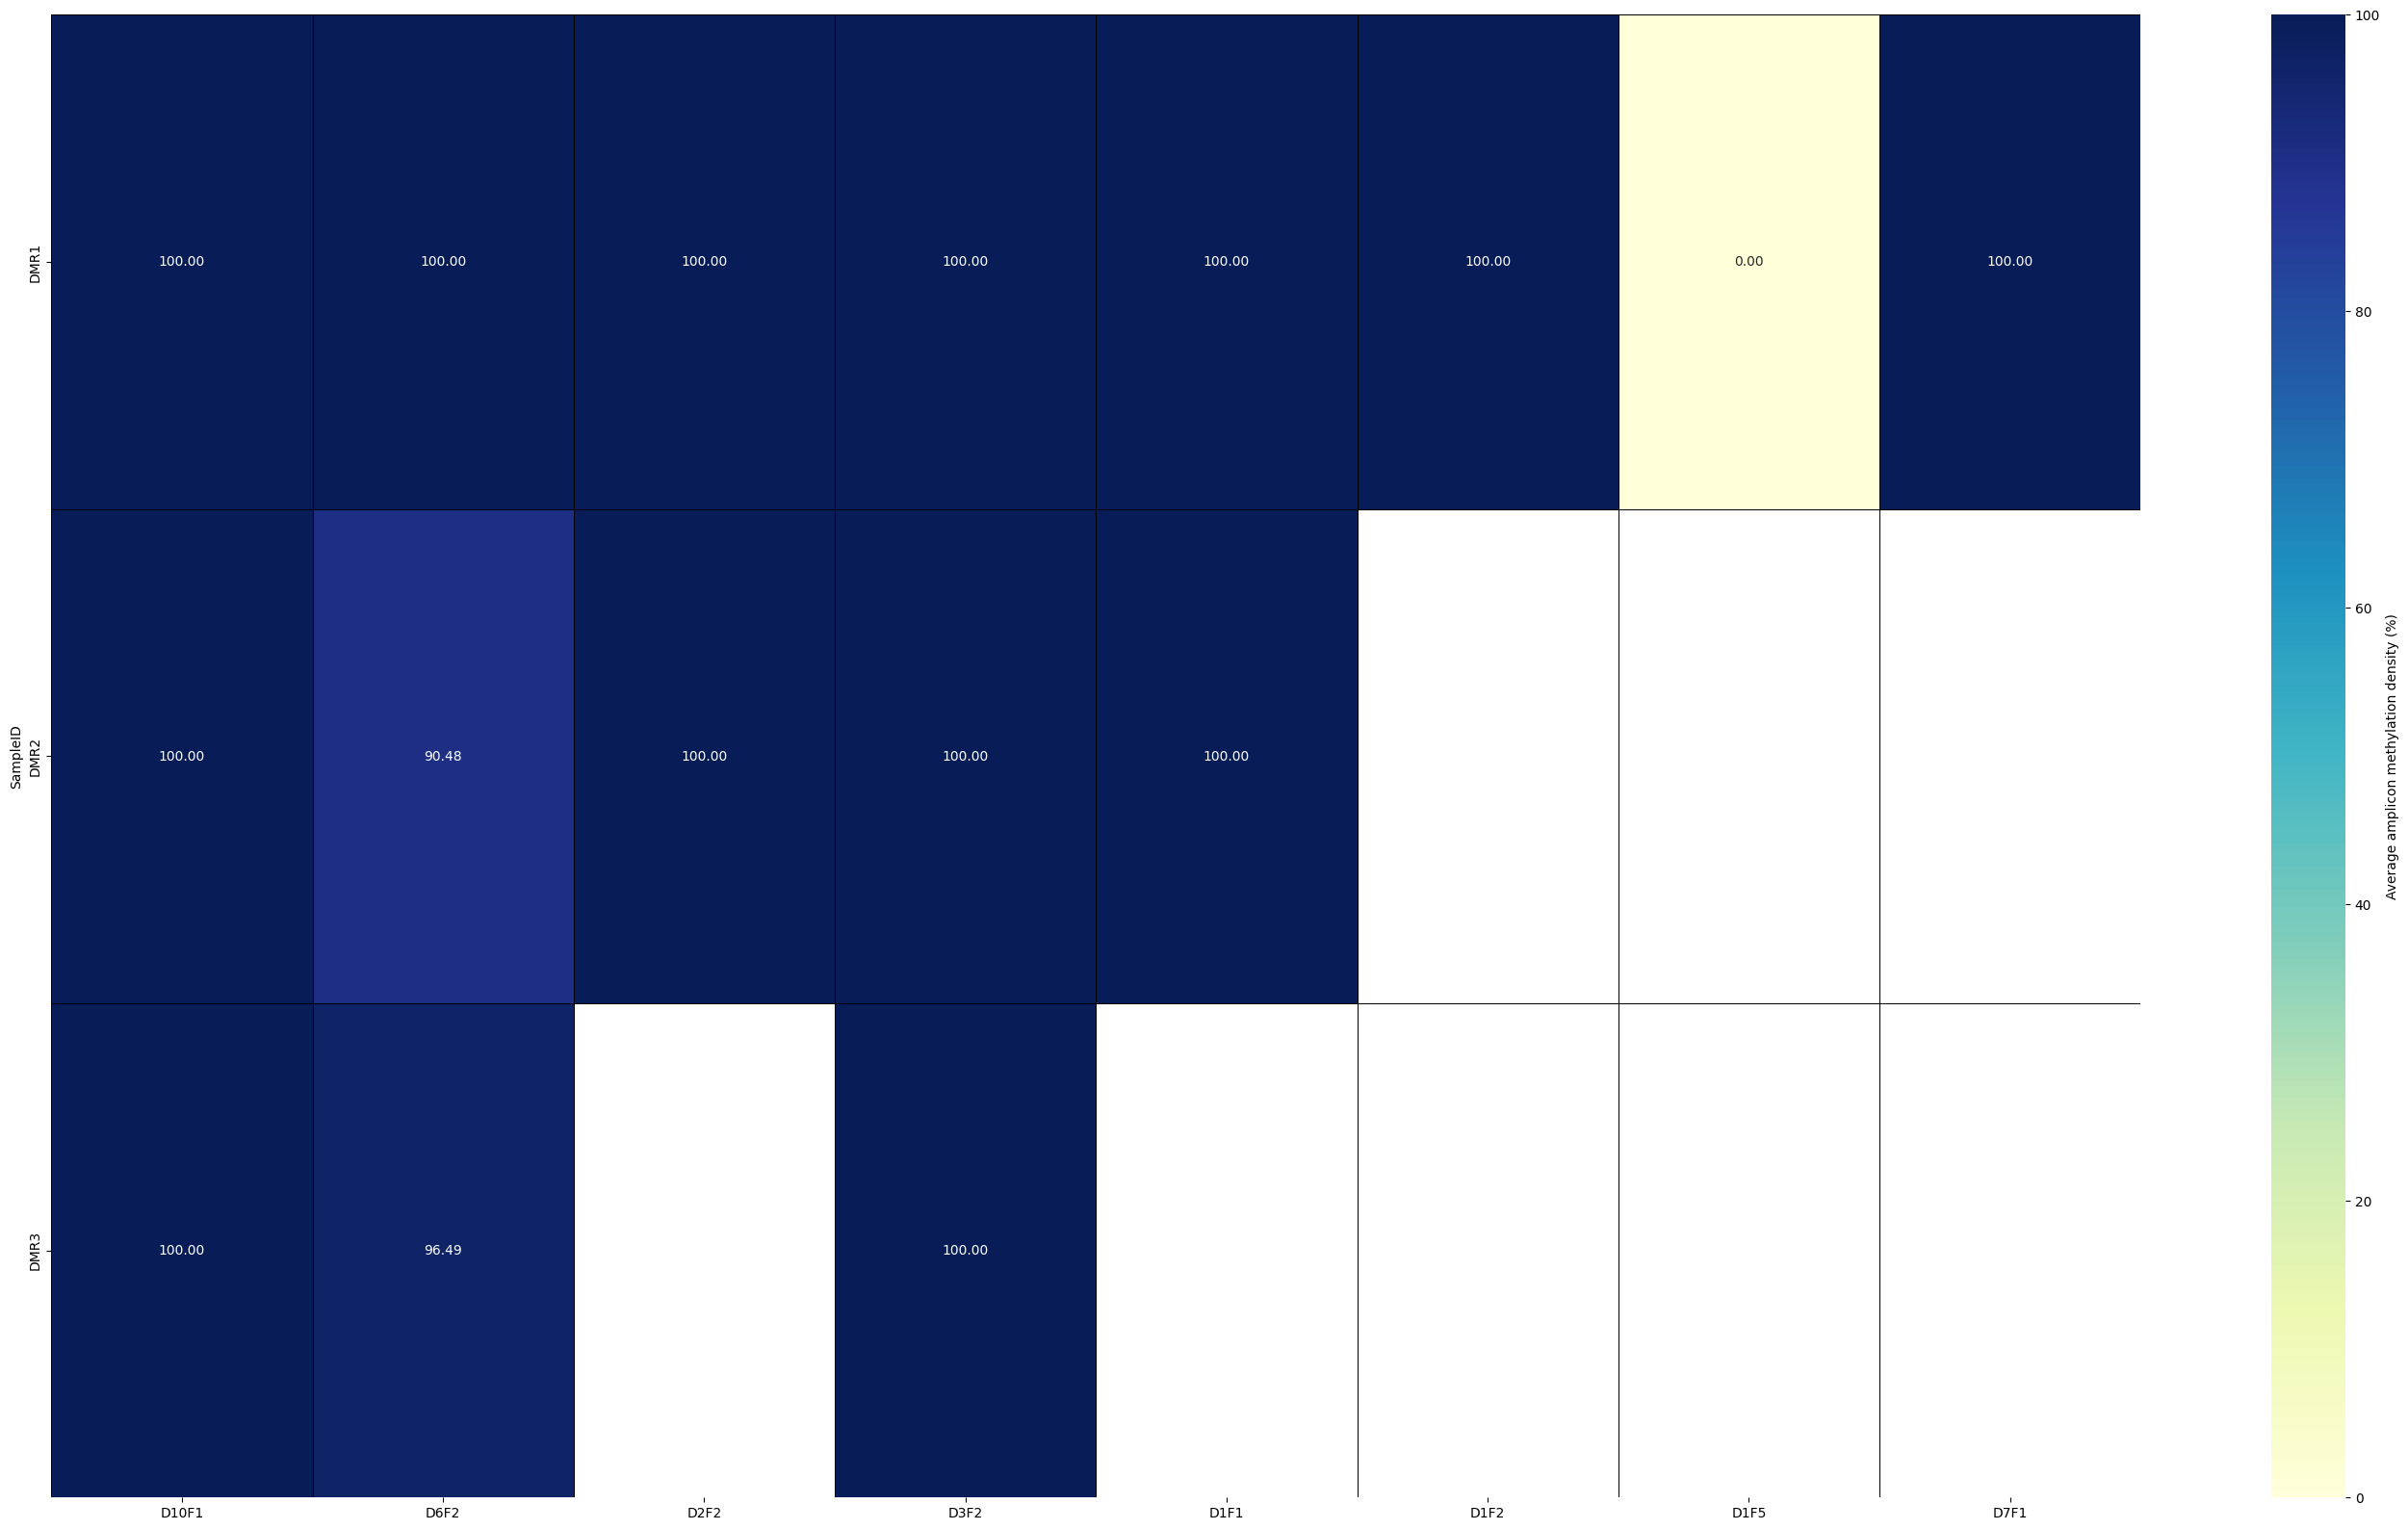

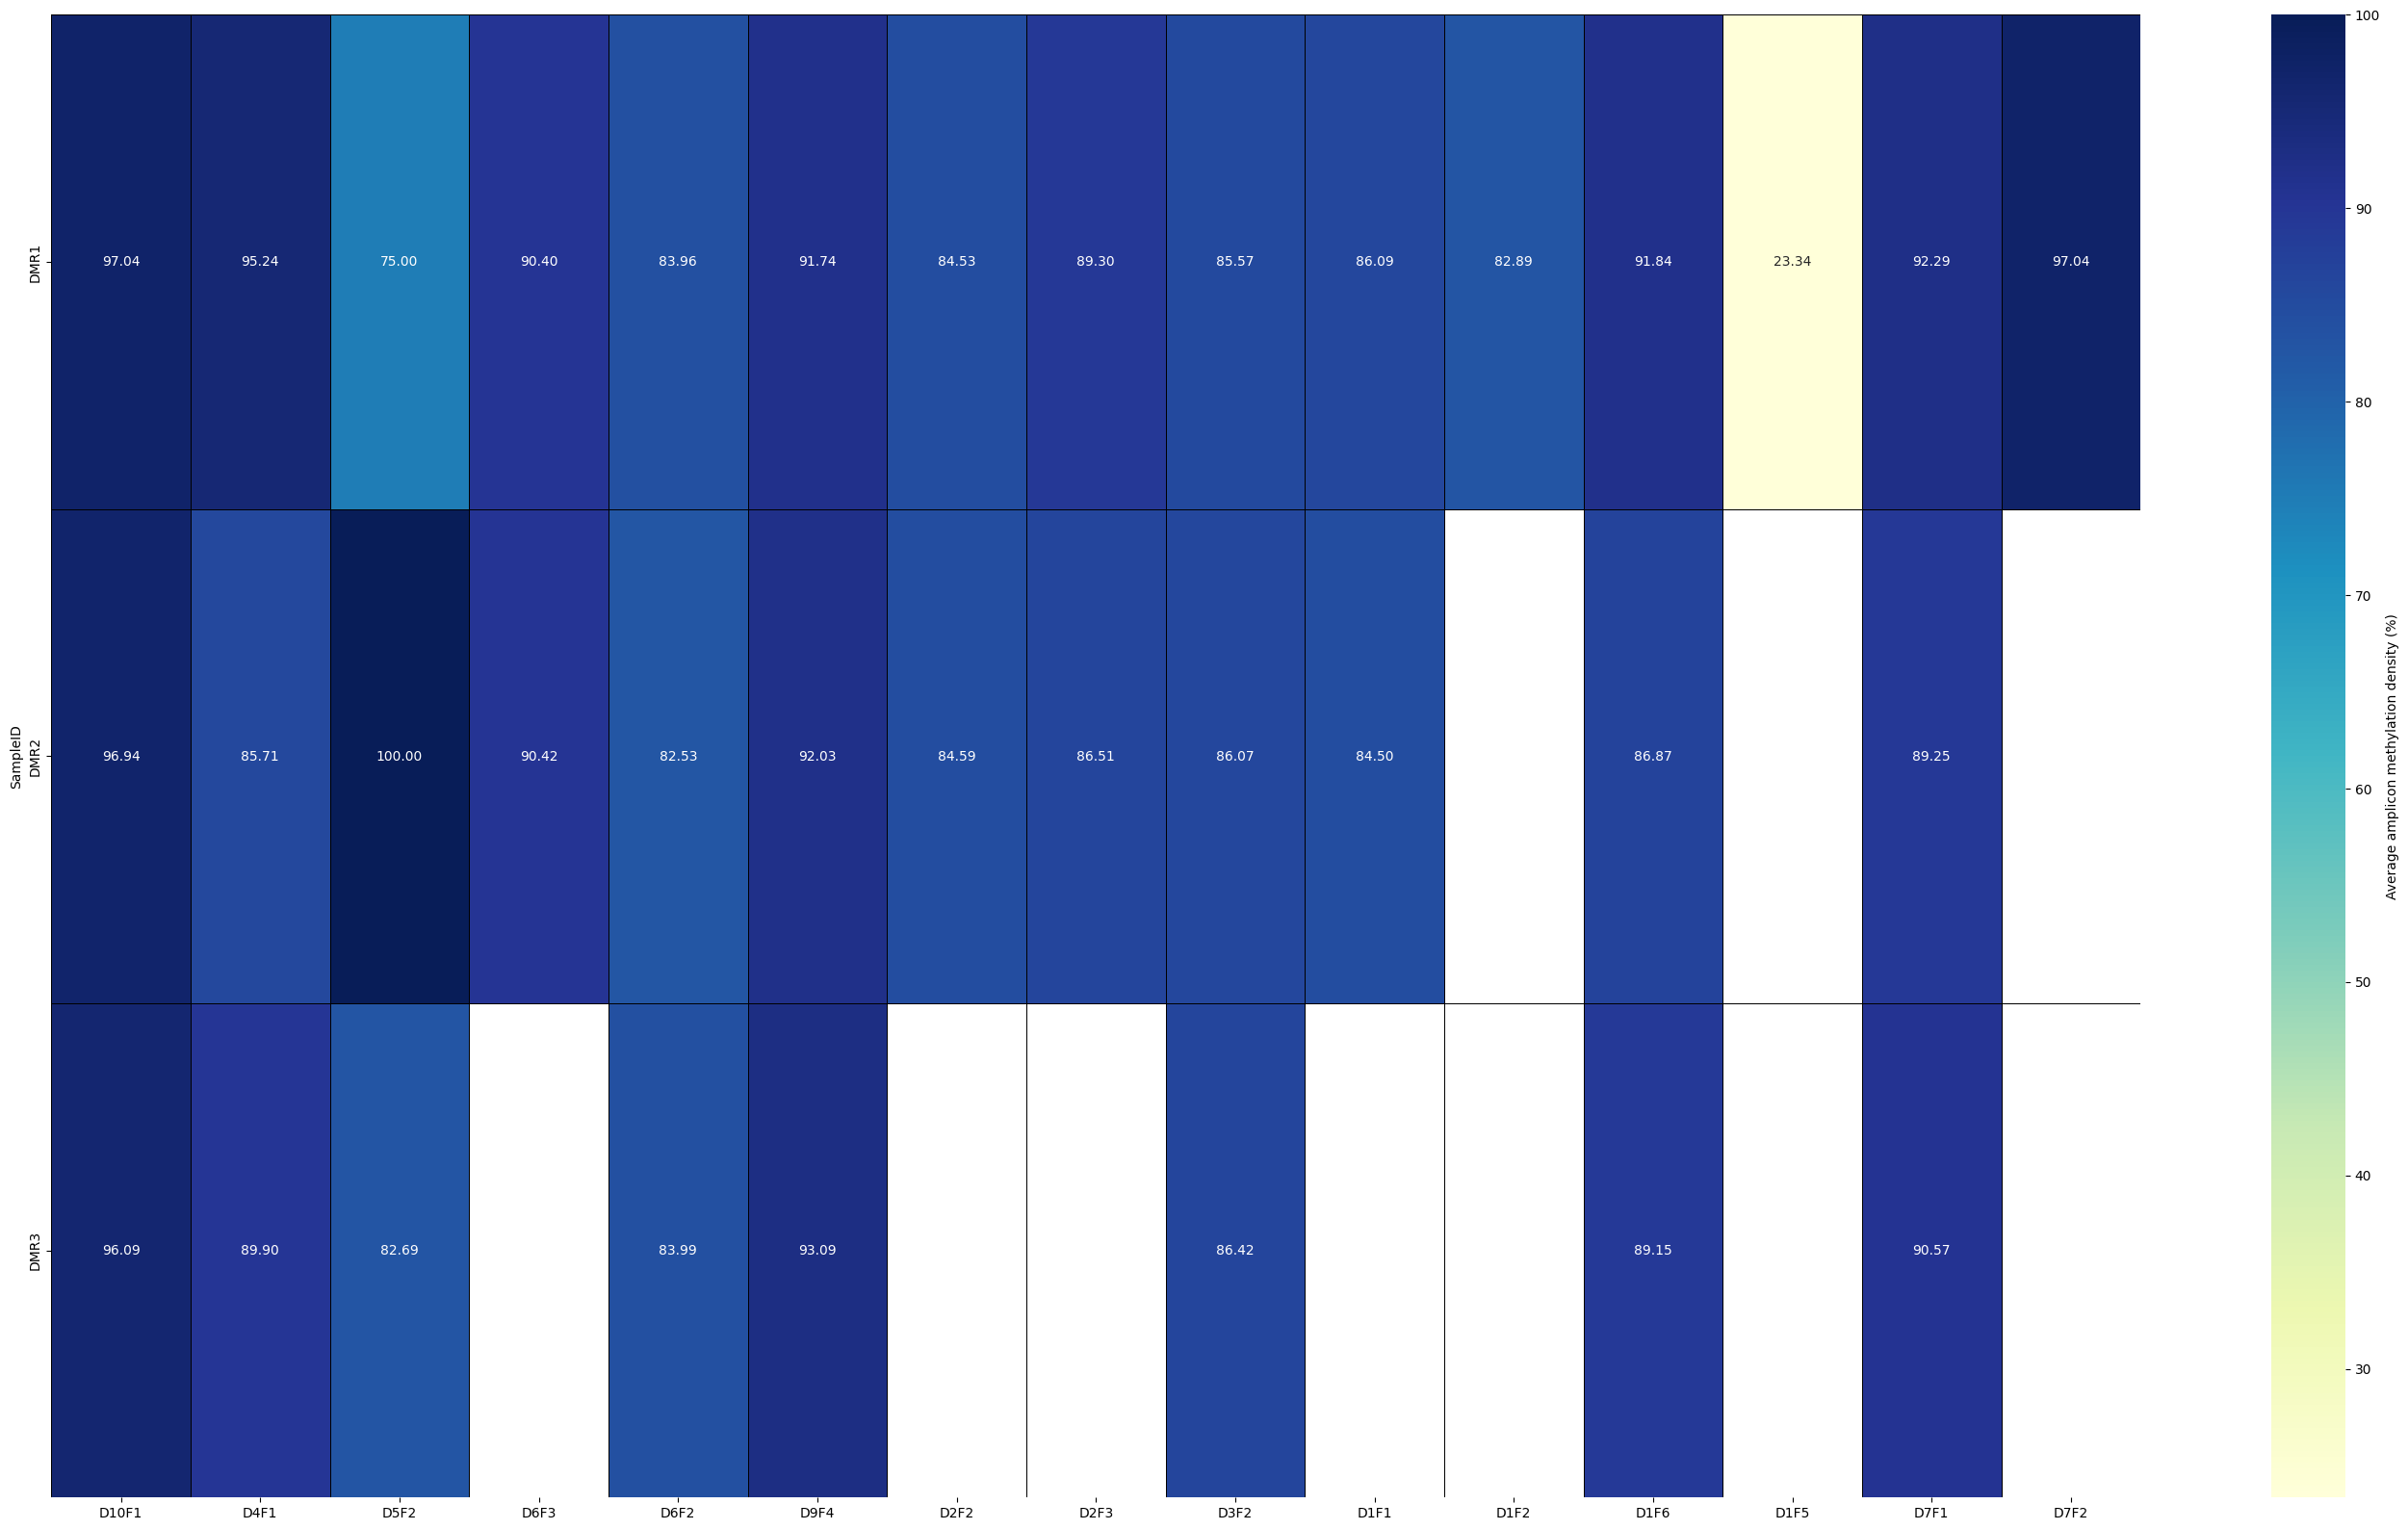

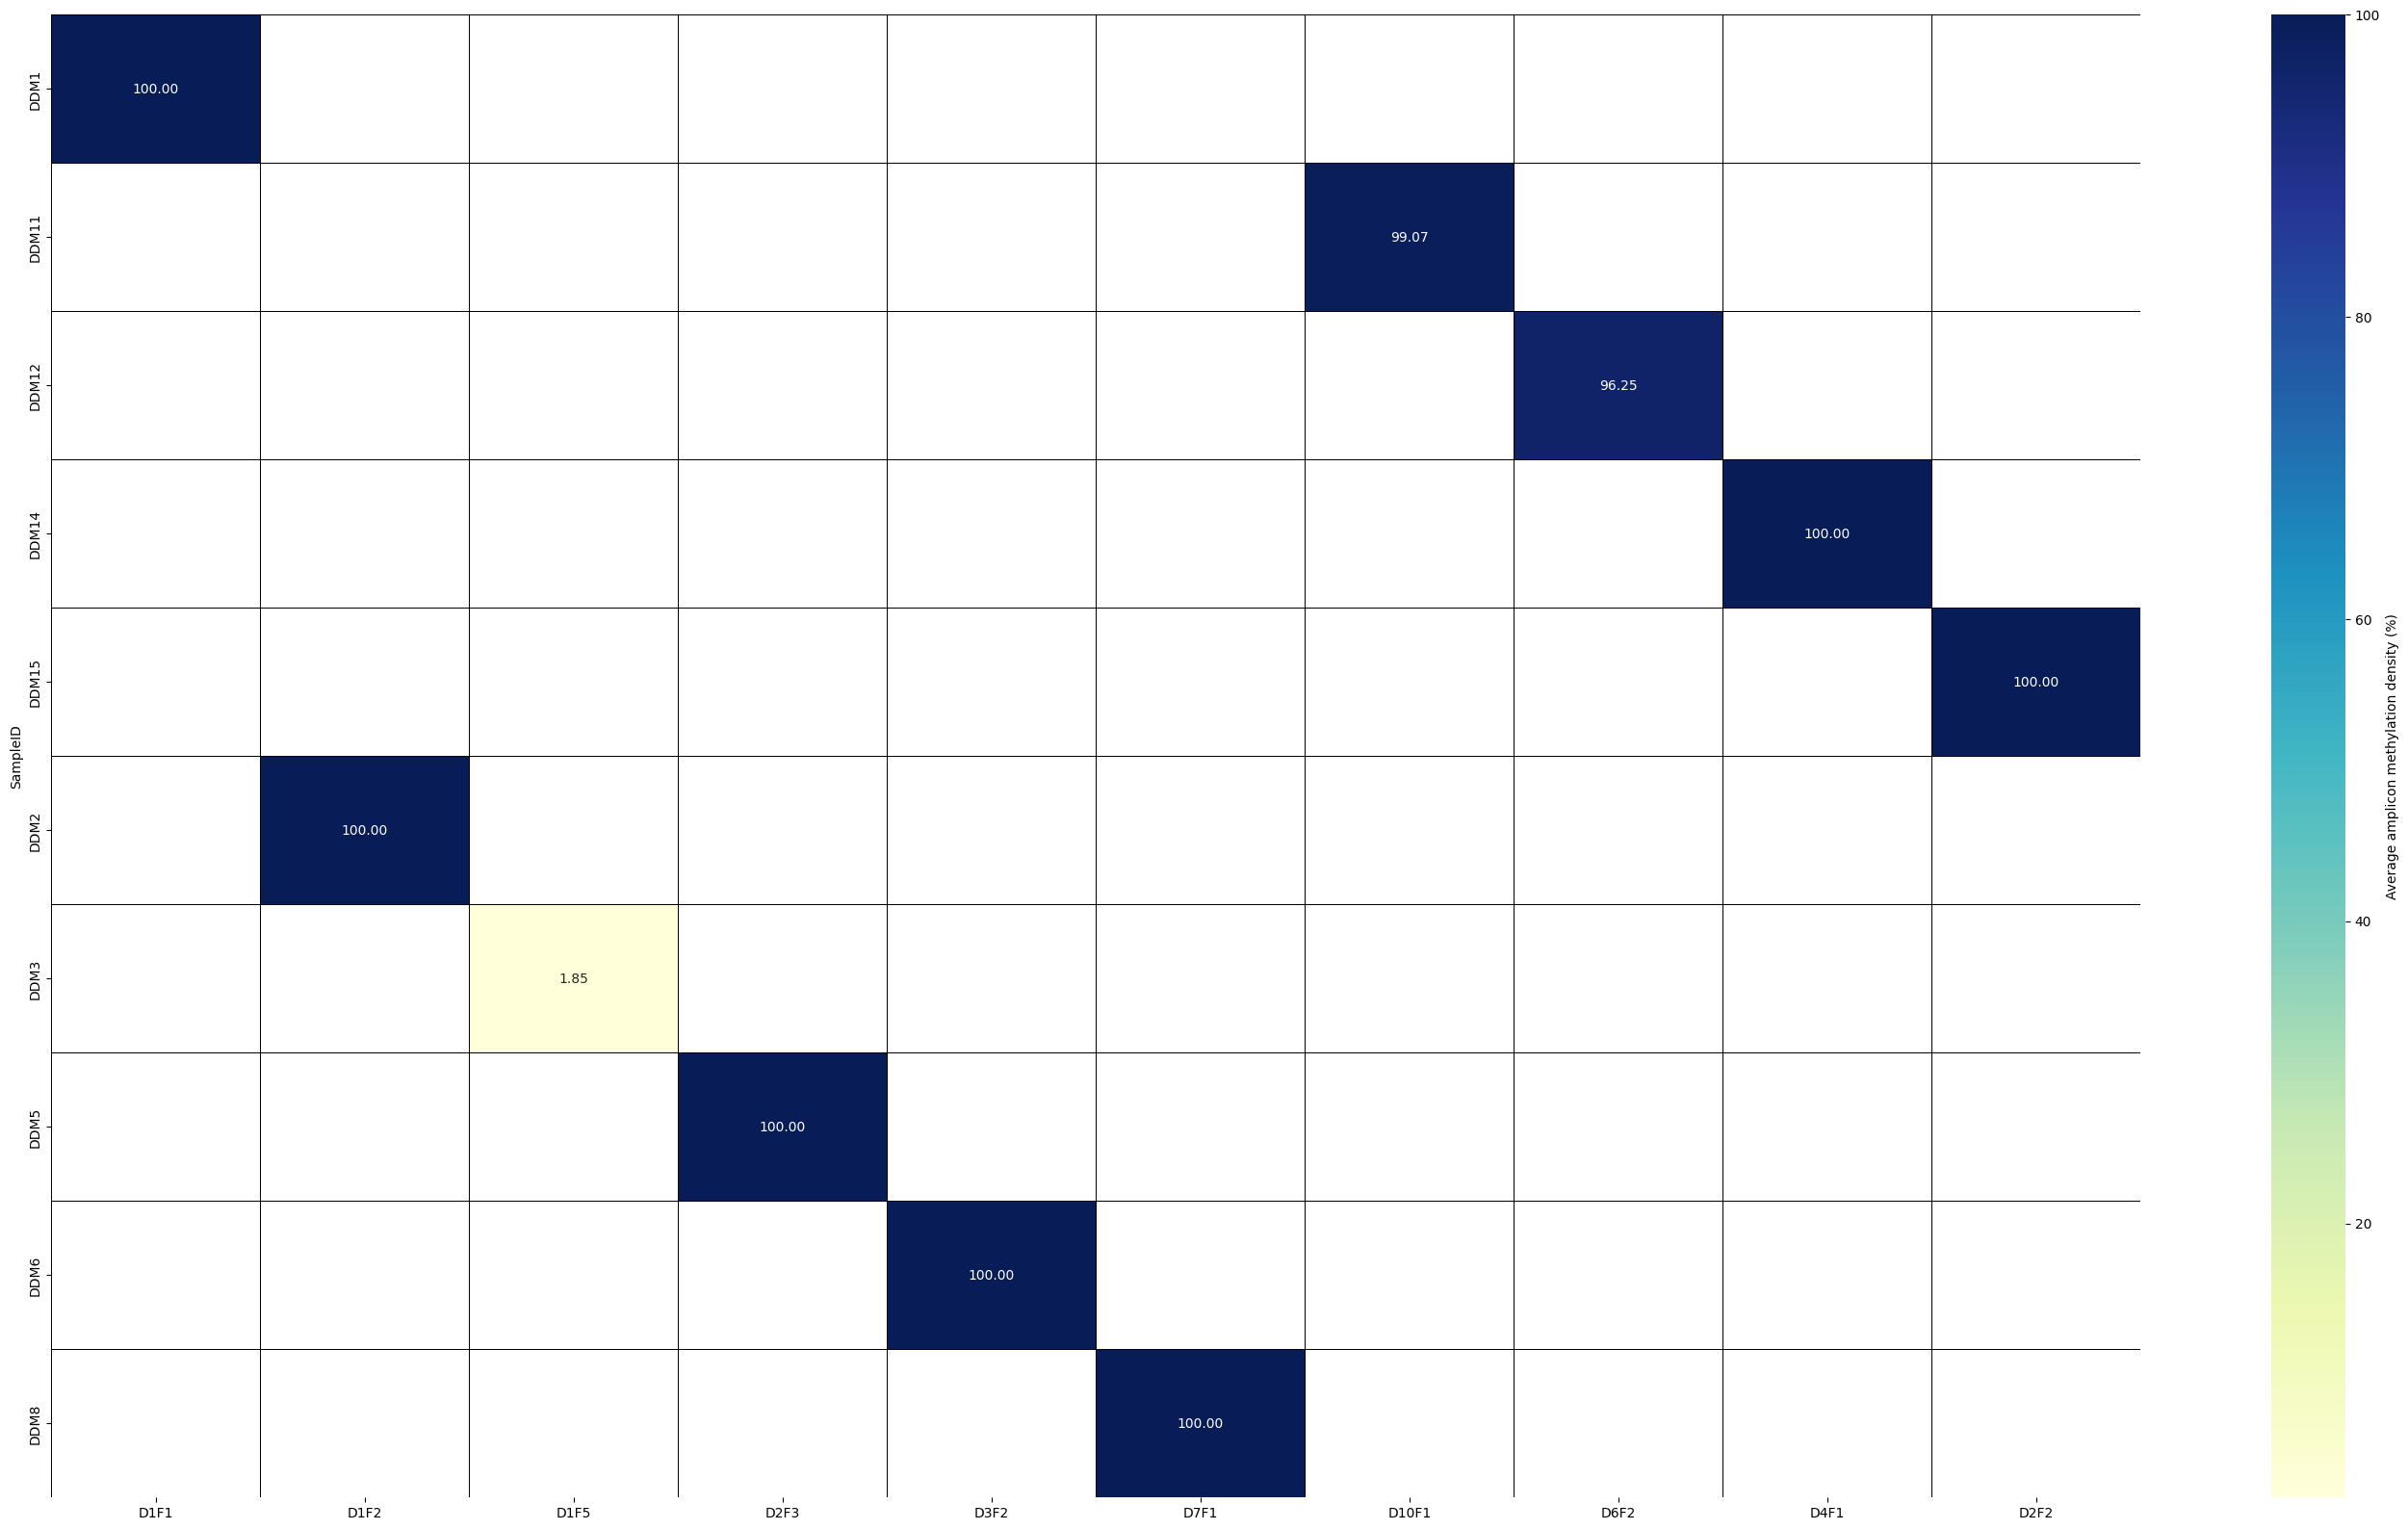

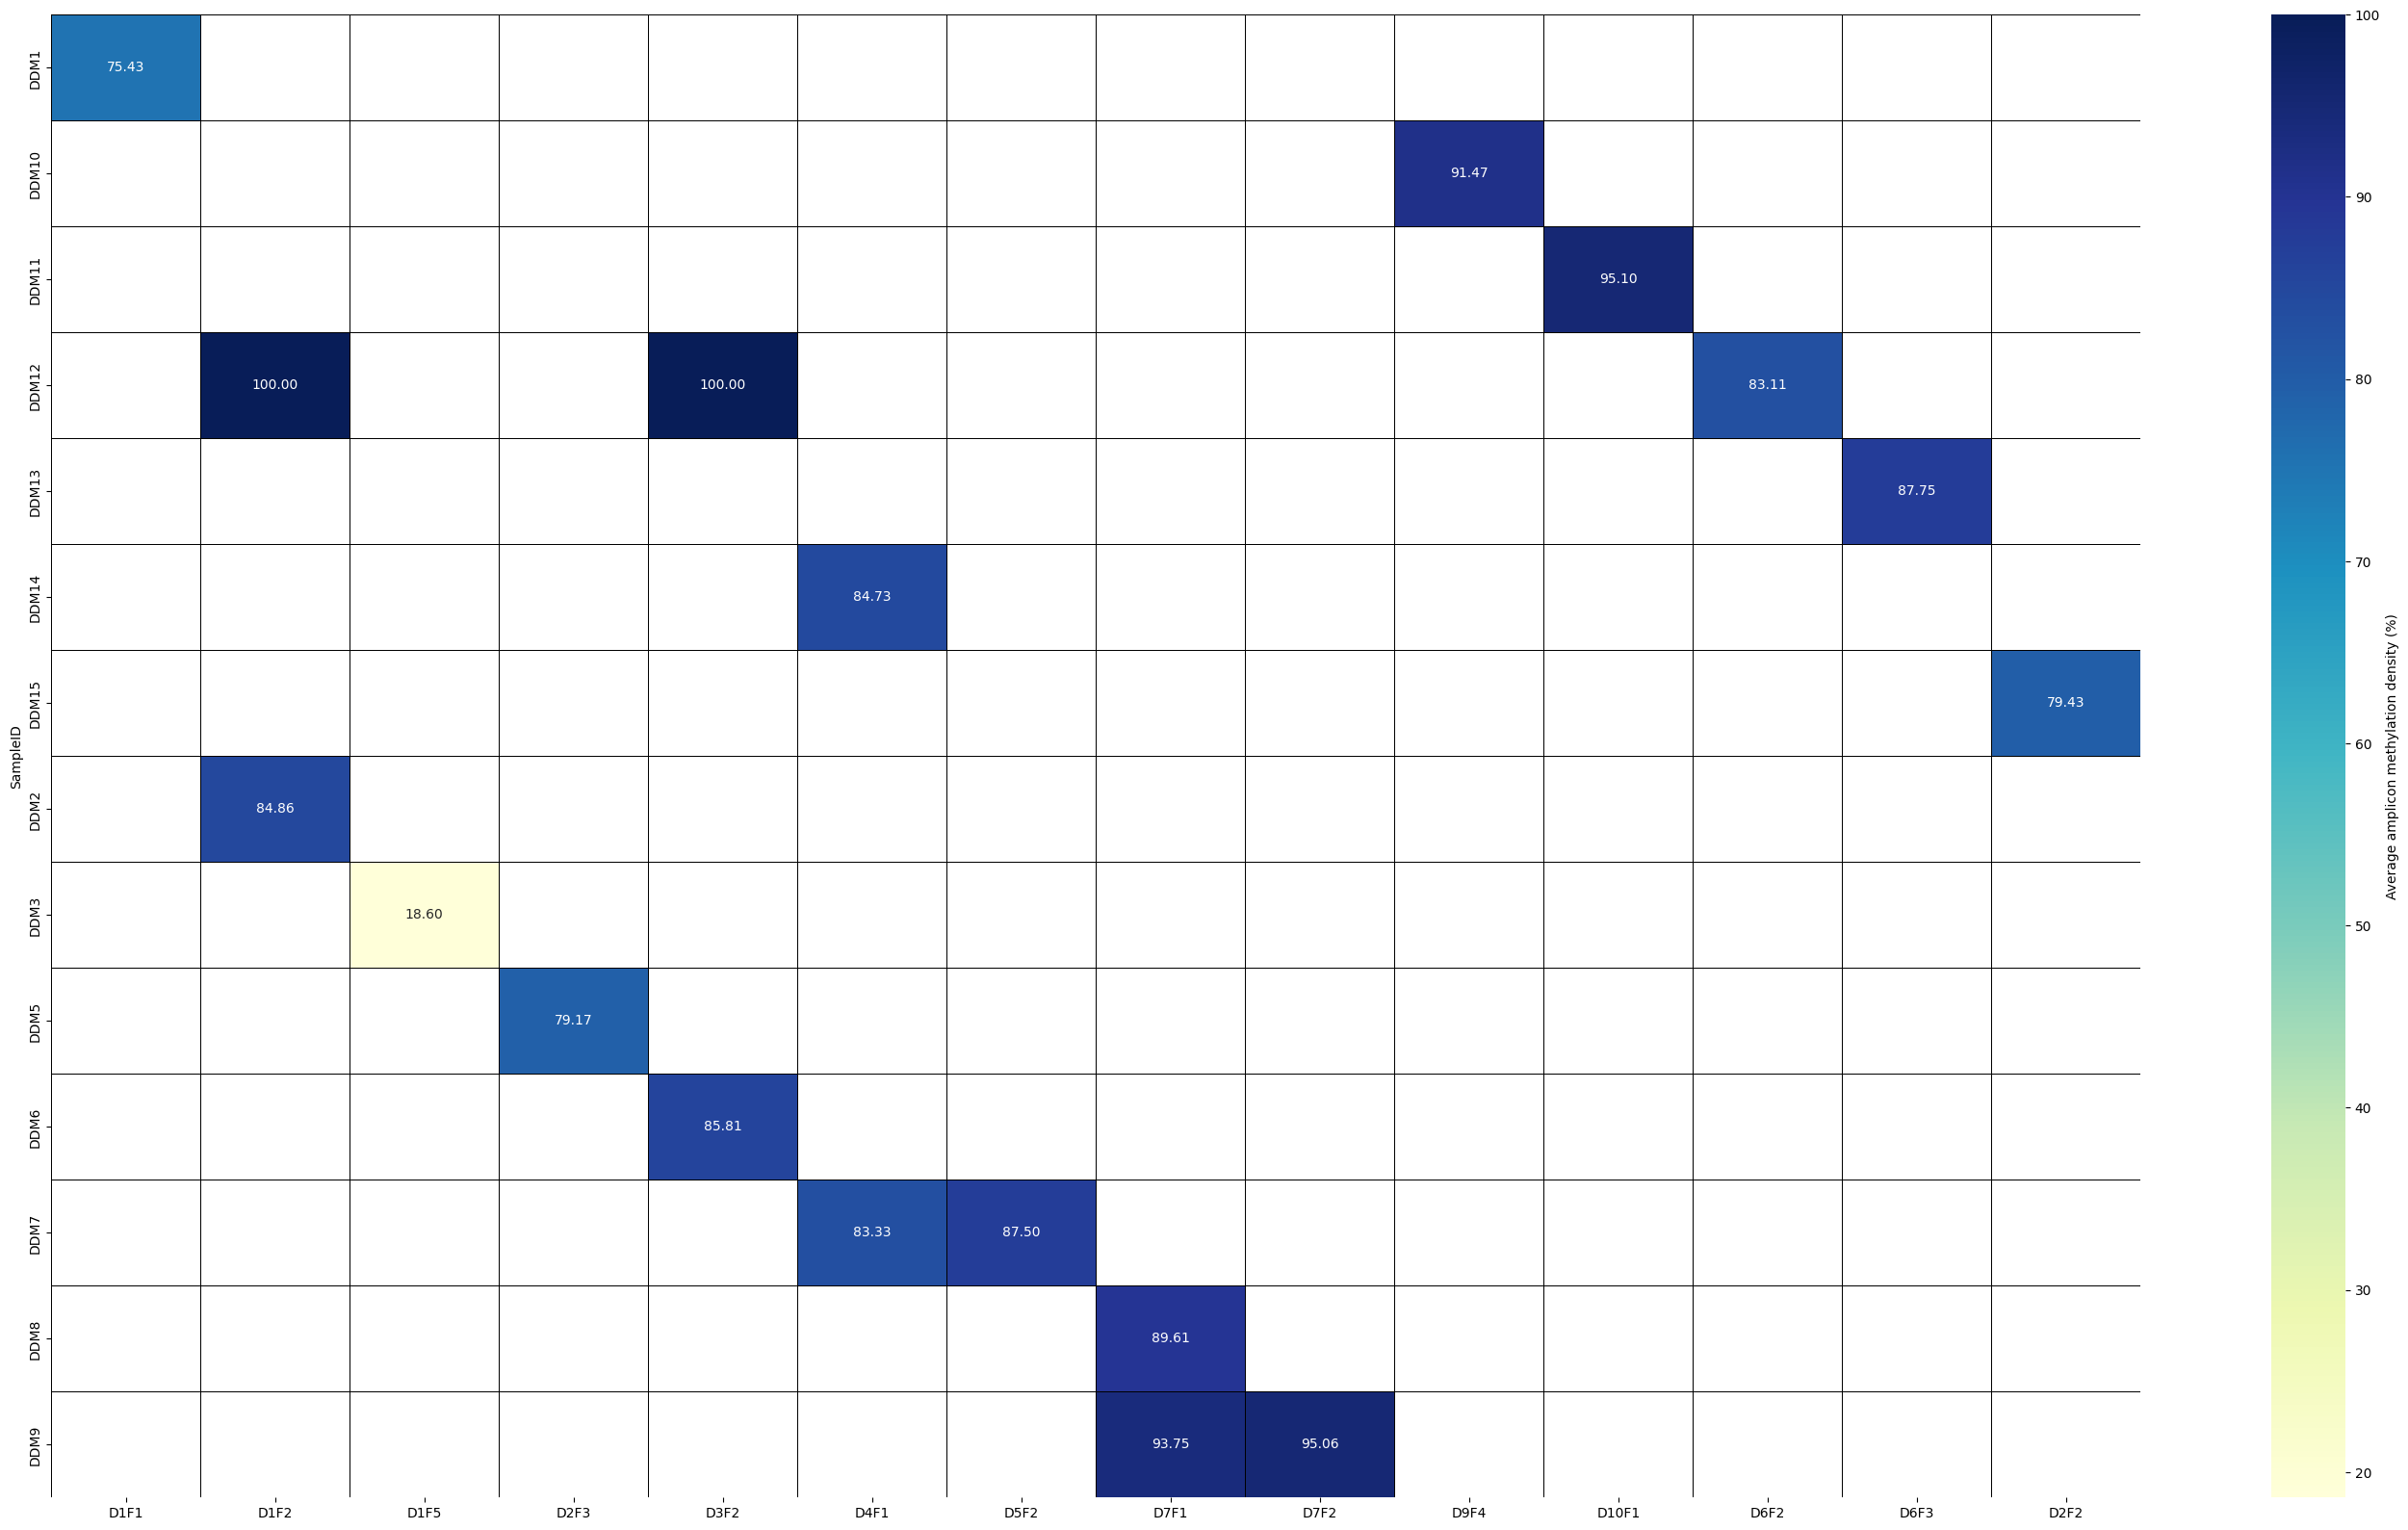

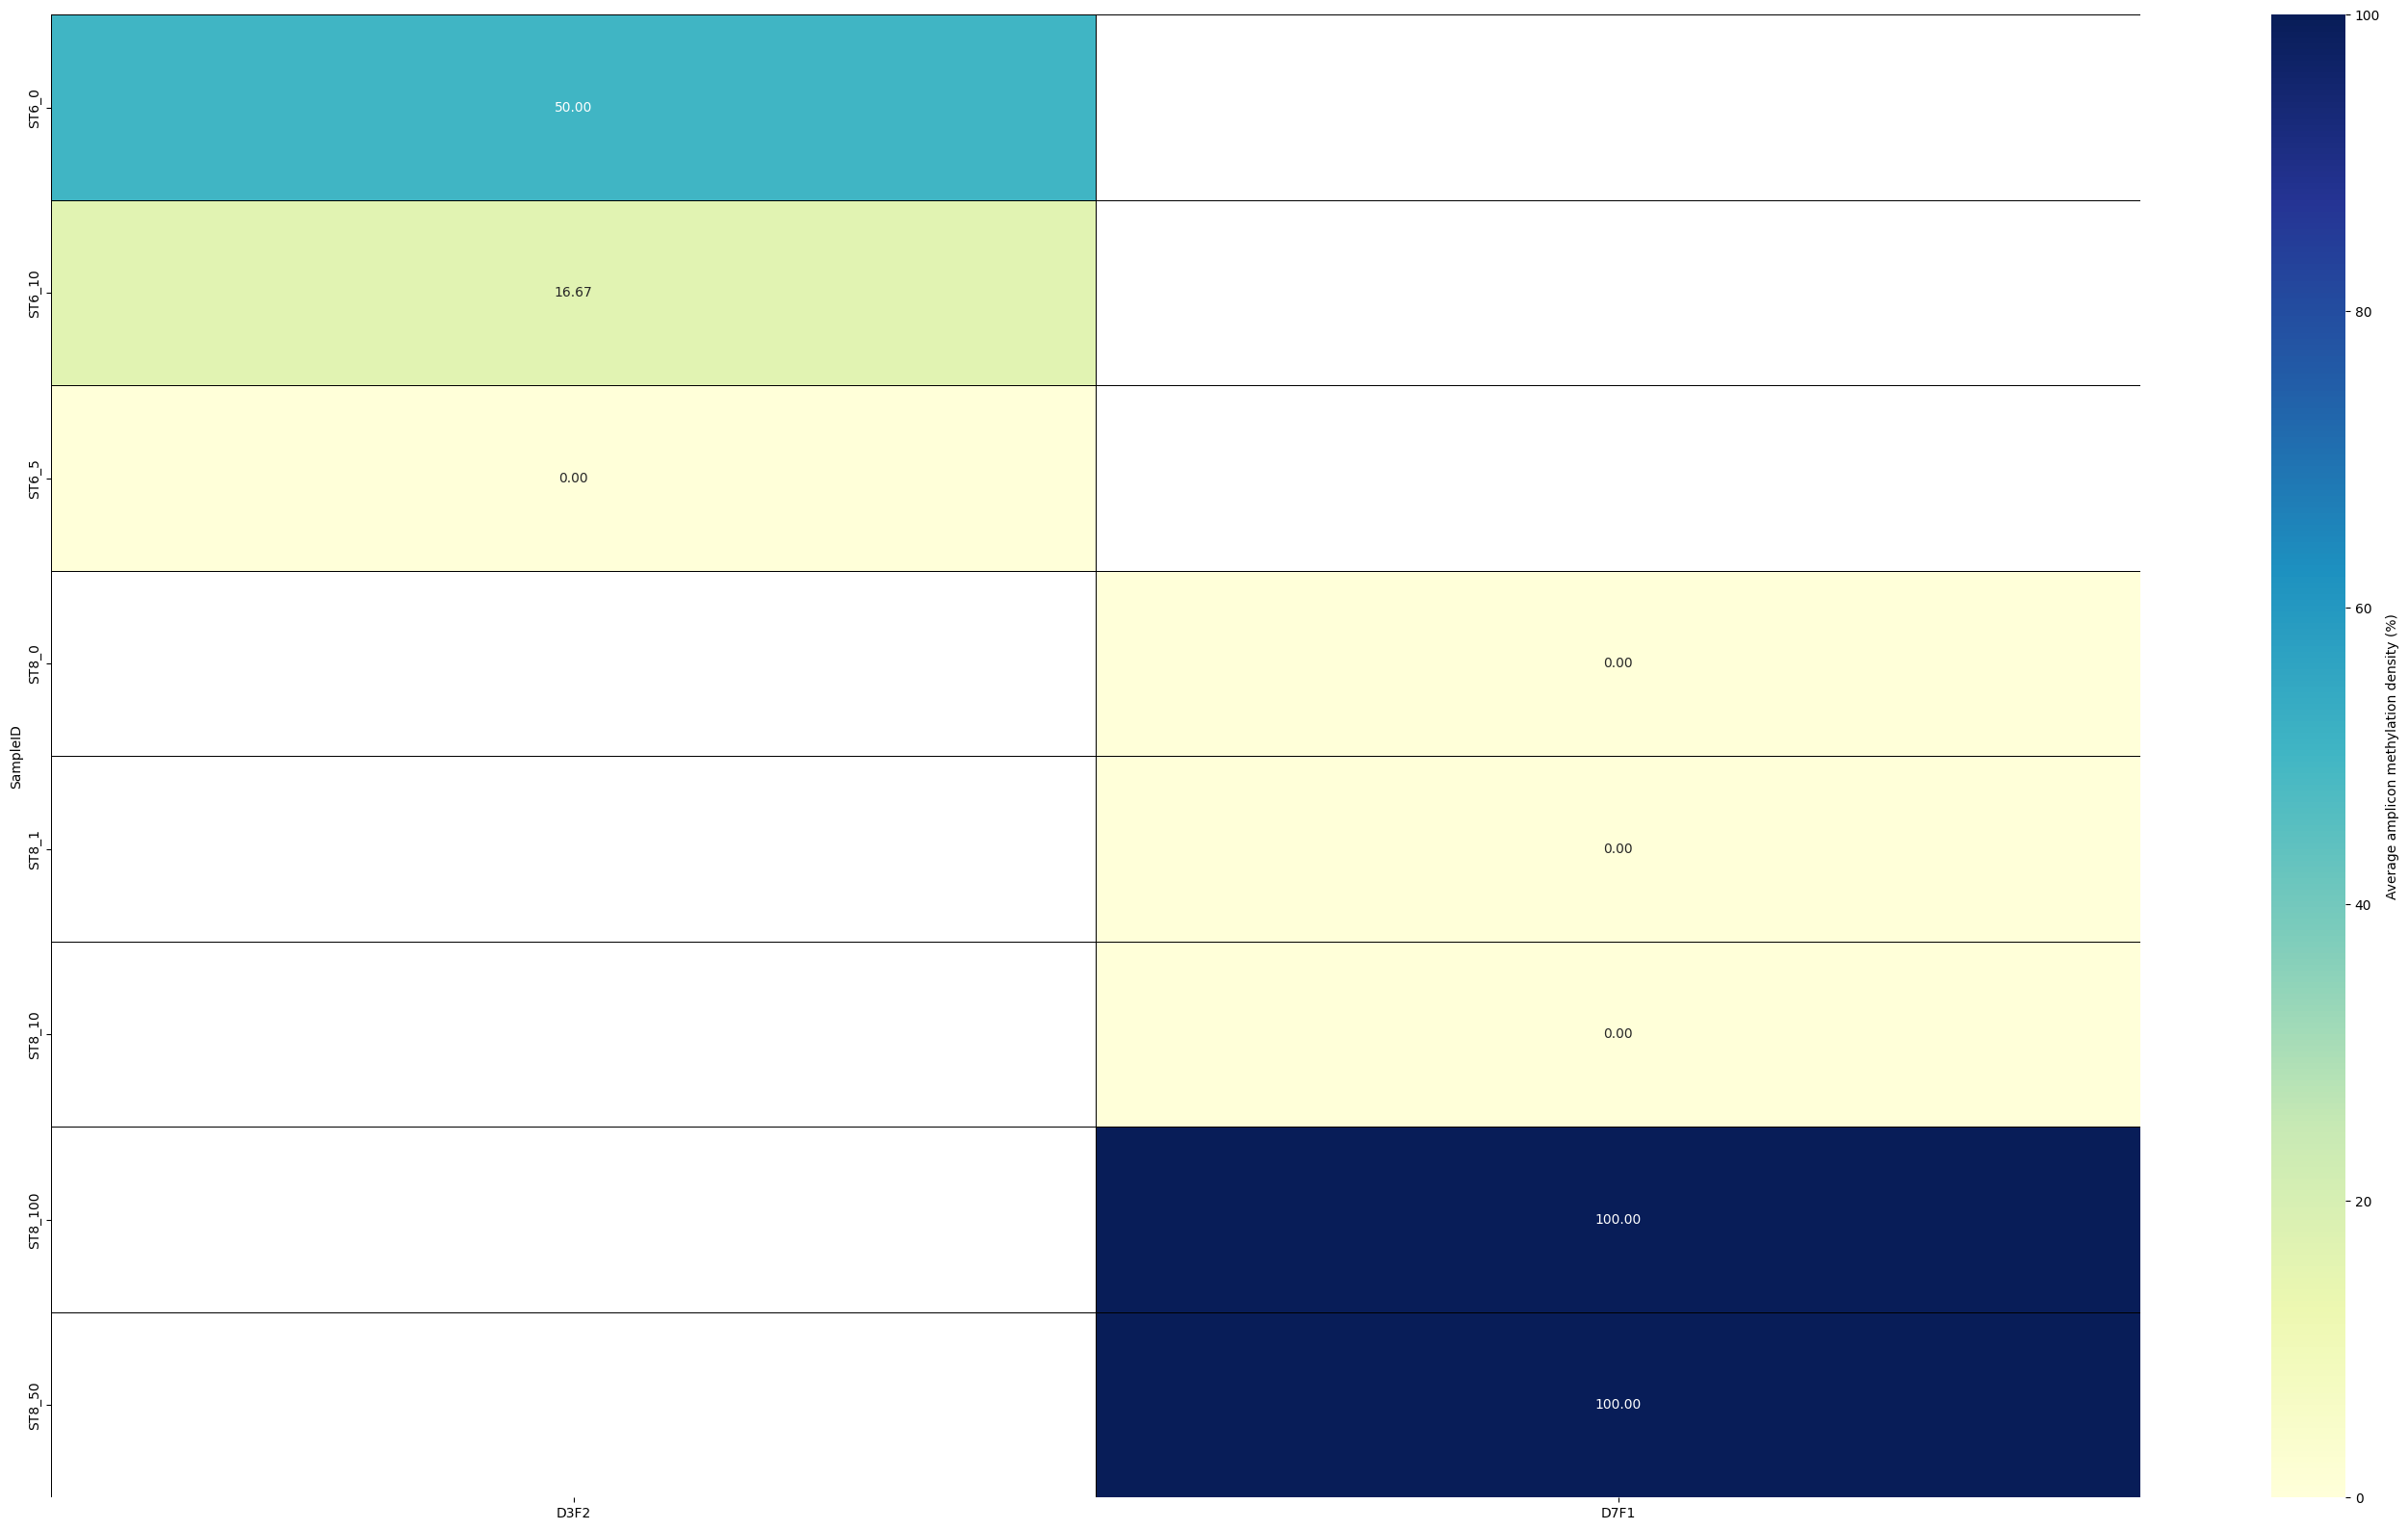

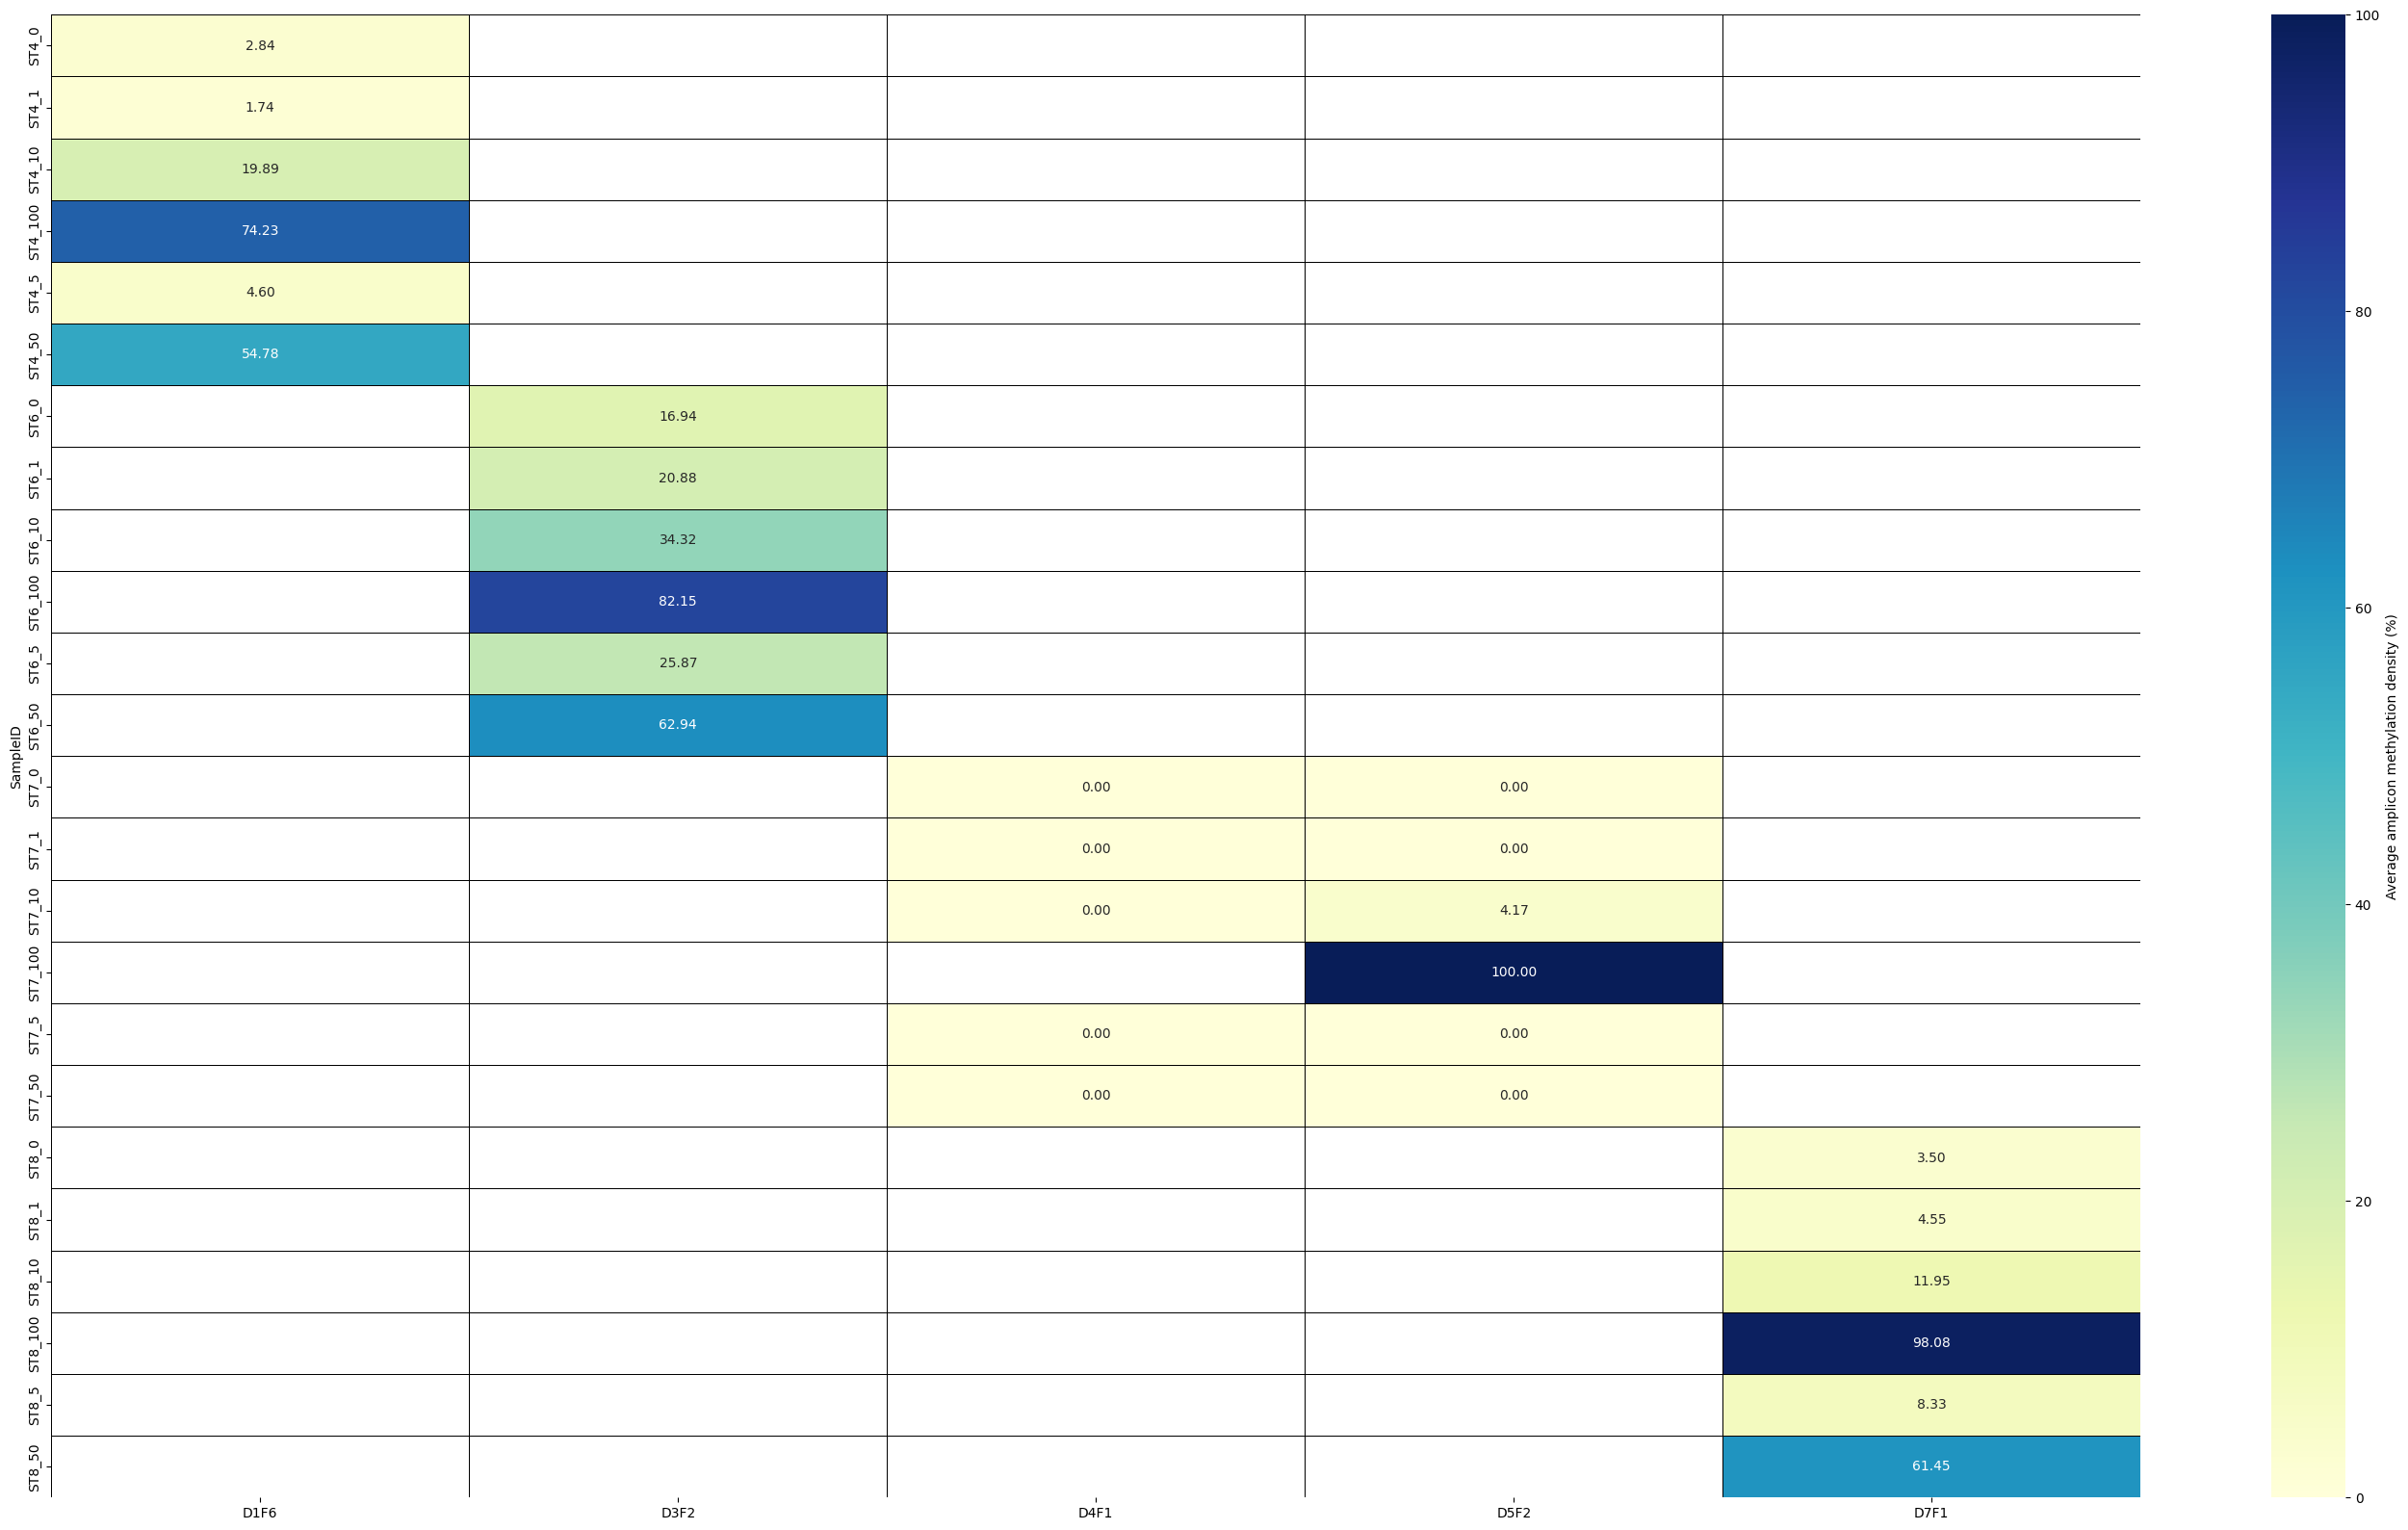

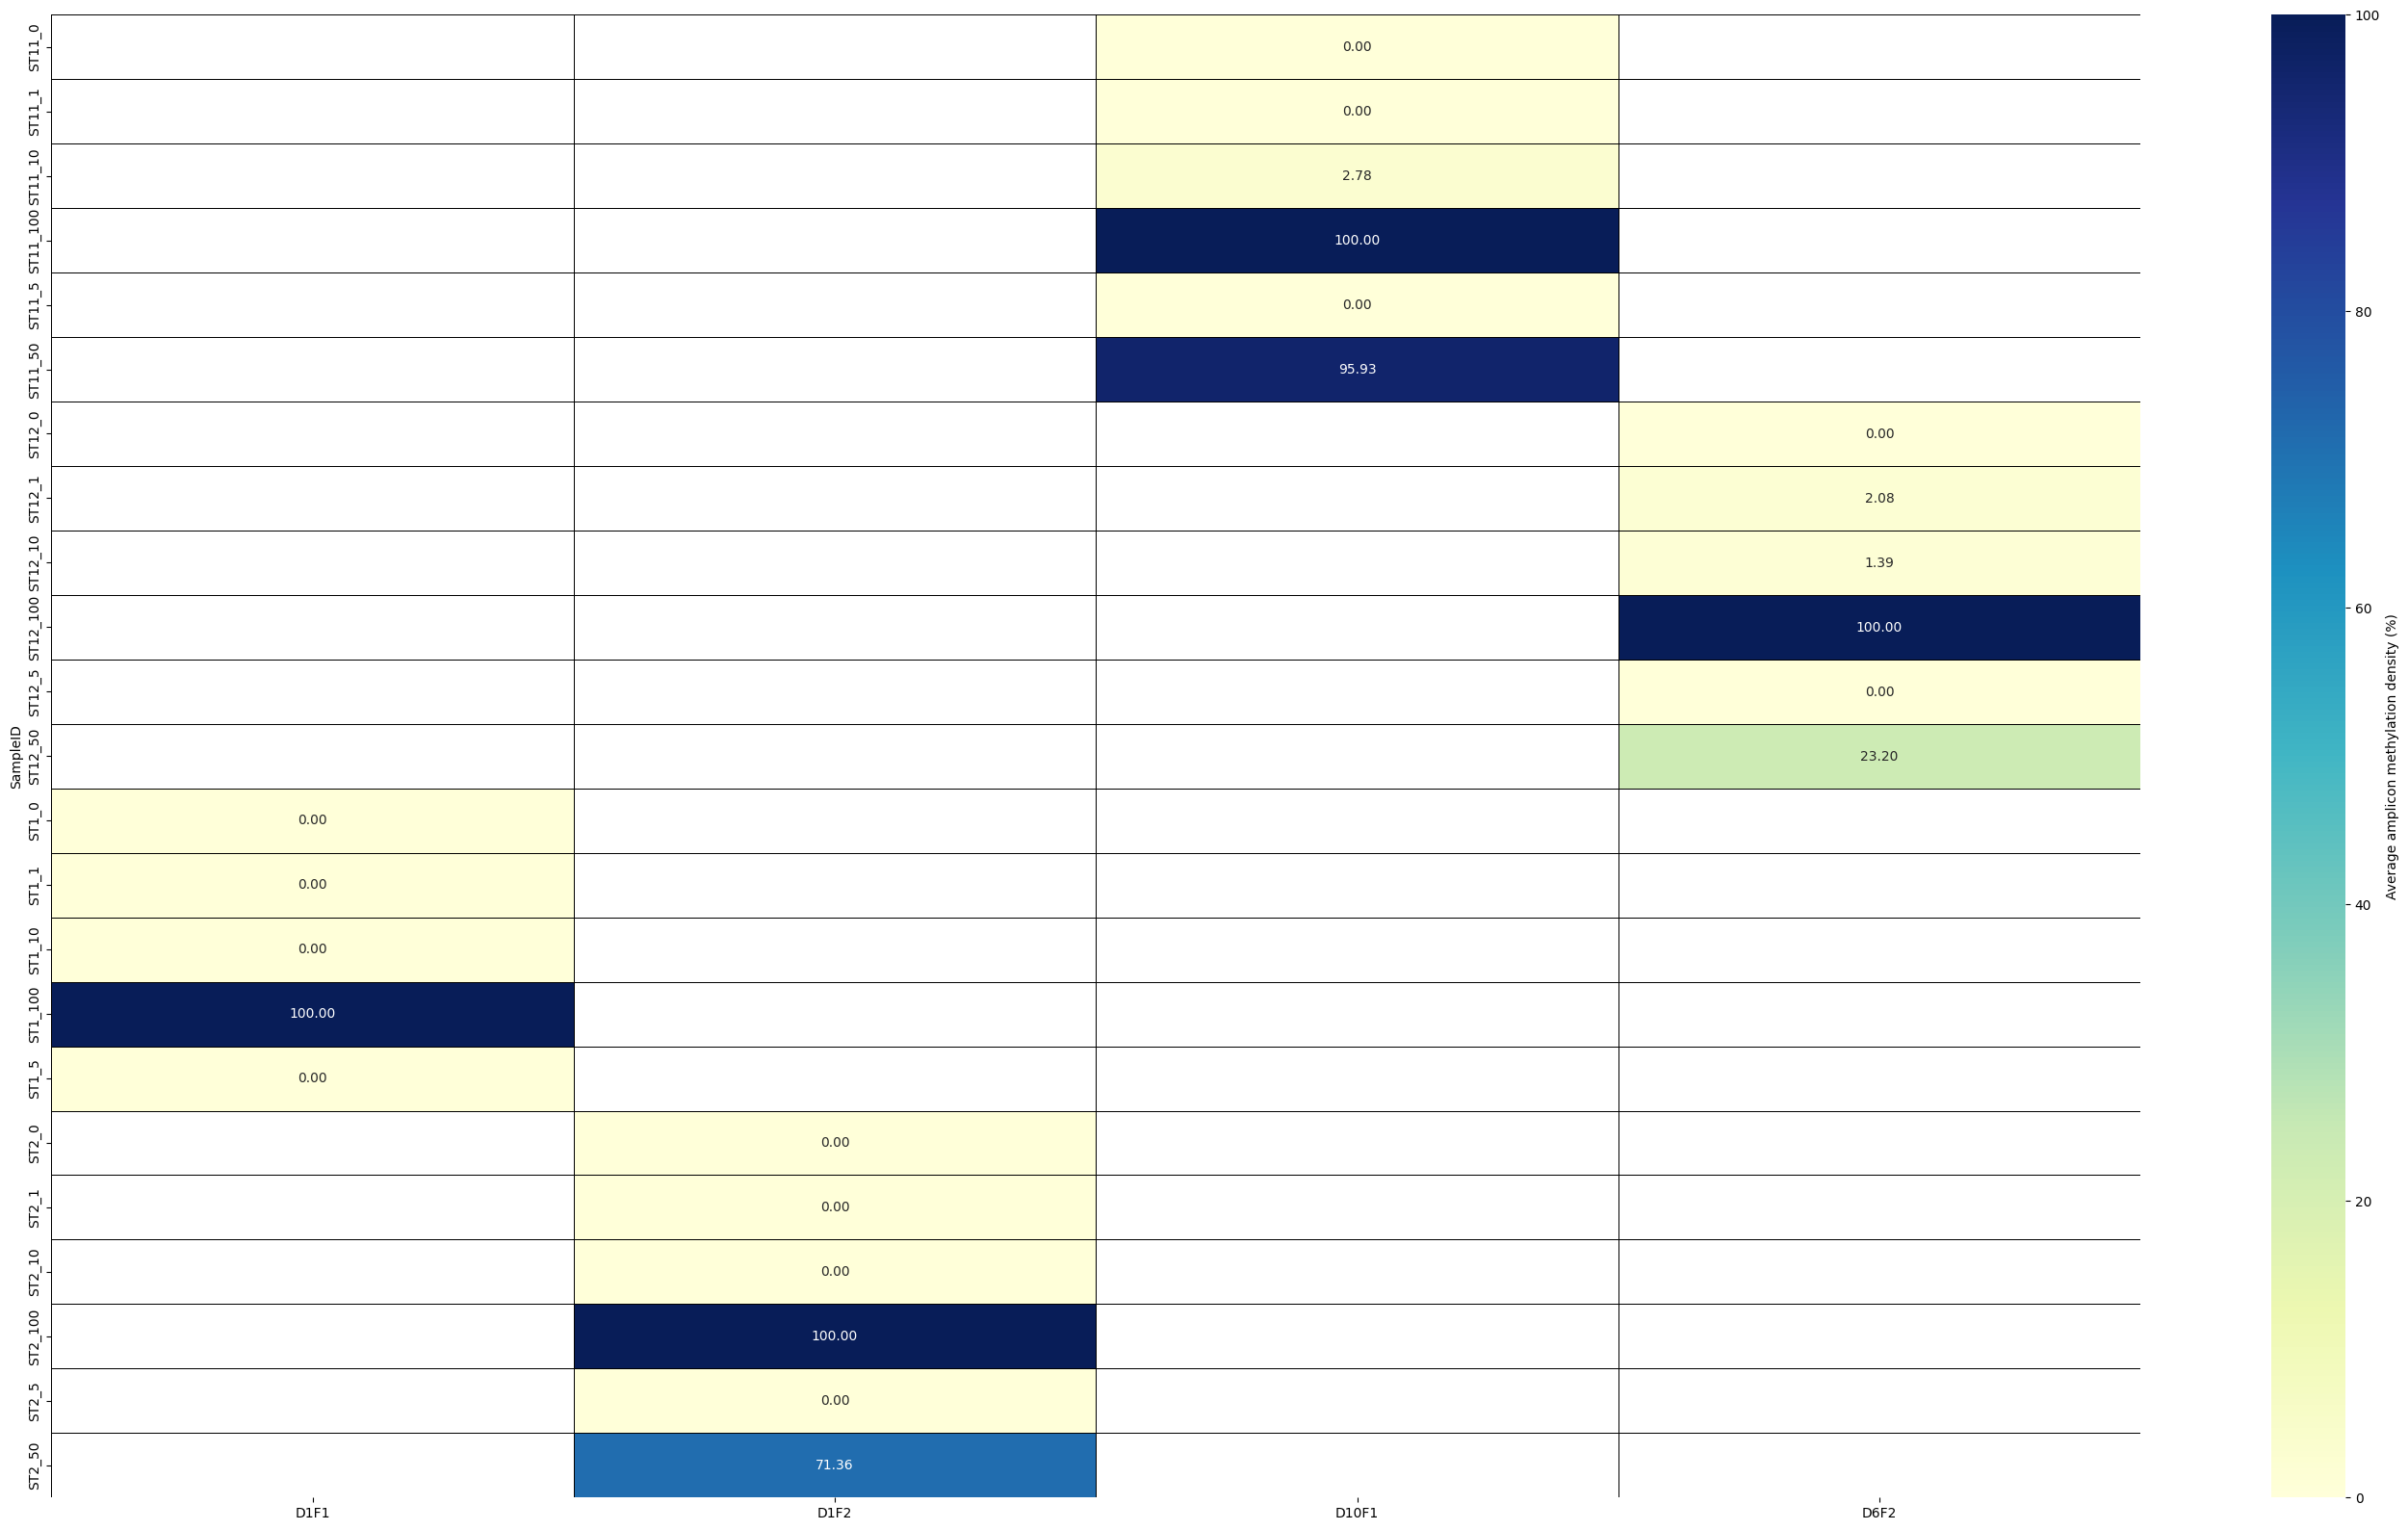

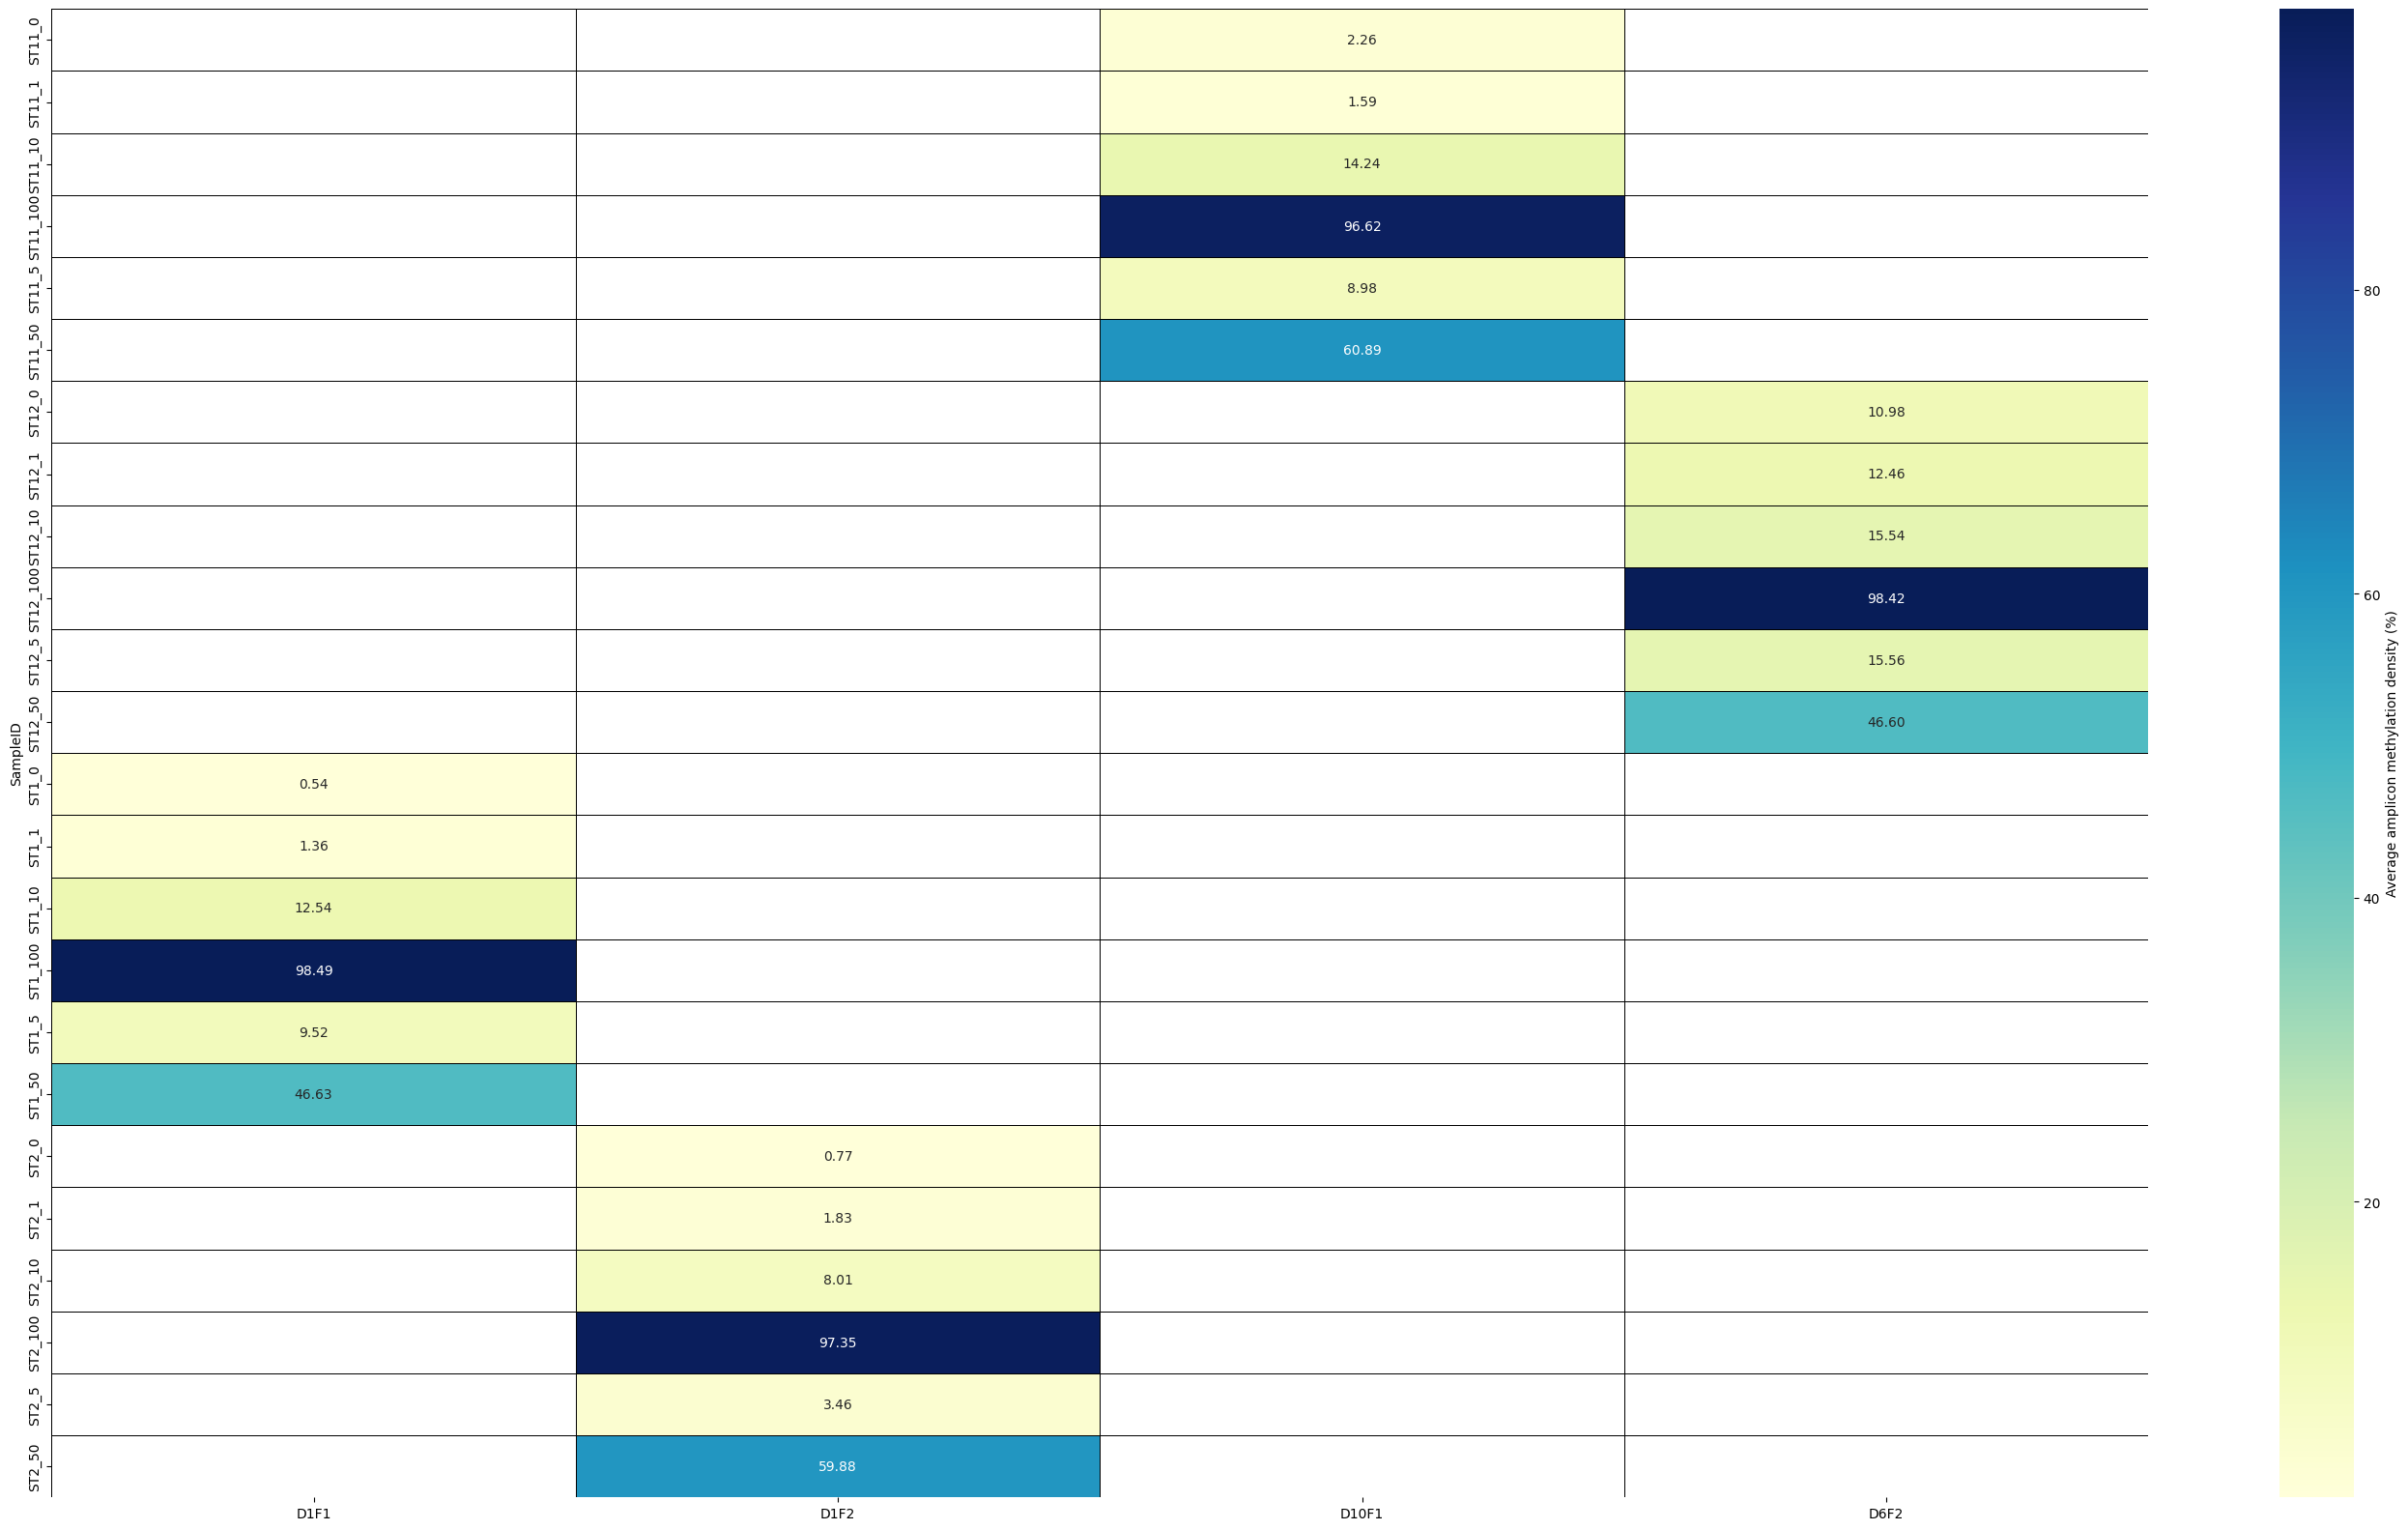

In [10]:
for run in final_umi_rundf.Run.unique():
# for run in ["R7400"]:
    for mode in ["UMI", "ignore_UMI"]:
        if mode == "UMI":
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "UMI_processed_cov"
            bampath = "umi_bam"
            total_col = "count_umi_bam"
        else:
            plot_metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                            (final_umi_rundf["ignore_UMI_status"] == "Processed")].sort_values(by = "SampleID")
            selected_cov = "ignore_UMI_processed_cov"
            bampath = "non_umi_bam"
            total_col = "count_non_umi_bam"

        run_panels = plot_metadata.Panel_version.unique()

        # check how many panels are available for this run
        print(f"Run {run} has {len(plot_metadata.Panel_version.unique())} panel(s), {', '.join(run_panels)}")
        
        for panel_name in run_panels:
            metadata = final_umi_rundf[(final_umi_rundf["Run"] == run) & 
                                       (final_umi_rundf["Panel_version"] == panel_name)
                                       & (final_umi_rundf[f"{mode}_status"] == "Processed")]
            panel_name = panel_name.replace(" ", "_")
            paneldf = all_paneldf[panel_name].copy()

            os.system(f"mkdir -p {os.path.join(path_to_01_output, 
                                                "methylation_matrix", 
                                                run,
                                                
                                                panel_name, 
                                                mode)}")
            
            methdf = pd.DataFrame()
            for sampleid in tqdm(metadata.SampleID.unique()):
                covdf = pd.read_excel(metadata[metadata["SampleID"] == sampleid][selected_cov].values[0])
                covdf = covdf[covdf["check_context"] == "CpG_context"]
                tmpdf = pd.DataFrame(data = [sampleid], columns = ["SampleID"])
                os.system(f"mkdir -p {os.path.join(path_to_01_output, "amplicon_cov", run, panel_name, mode,  sampleid)}")
                for amplicon in covdf["amplicon"].unique():
                    amplicon_covdf = covdf[covdf["amplicon"] == amplicon].copy()
                    tmpdf[amplicon] = amplicon_covdf["meth_density"].mean()
                    if amplicon_covdf.shape[0] > 0:
                        amplicon_covdf.to_excel(os.path.join(path_to_01_output, "amplicon_cov", run, panel_name, mode,  sampleid, f"{sampleid}_{amplicon}_cov.xlsx"), index = False)
                tmpdf.fillna(0, inplace = True)
                methdf = pd.concat([methdf, tmpdf], axis = 0)
            methdf.sort_values(by = "SampleID", inplace = True)
            methdf.to_excel(os.path.join(path_to_01_output, 
                                                "methylation_matrix", 
                                                run,
                                                panel_name, 
                                                mode,
                                                "avg_methylation_density_in_amplicons.xlsx"), index = False)
            plt.figure(figsize=(35, 20))
            plt.tight_layout()
            sns.heatmap(methdf.set_index("SampleID"),cmap="YlGnBu", fmt=".2f", annot=True, linewidths=.5, linecolor='black', cbar_kws={"label": "Average amplicon methylation density (%)"})
            plt.savefig(os.path.join(path_to_01_output, 
                                                "methylation_matrix", 
                                                run,
                                                panel_name, 
                                                mode,
                                                "avg_methylation_density_in_amplicons.png"), dpi=300, bbox_inches='tight')